# Подключаем нужные библиотеки

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import numpy as np
from numpy.linalg import norm
import pickle
import matplotlib.pyplot as plt
import itertools
from scipy.stats import norm as norm_d
from scipy.stats import randint
from scipy.stats import uniform
from scipy.optimize import minimize
import copy
import math
import time
from scipy.optimize import minimize
from scipy.sparse.linalg import svds
from scipy.linalg import svdvals
import scipy
from sklearn.datasets import load_svmlight_file
import pickle
from pathlib import Path
from functions import *
from algorithms import *
from tests import *

%matplotlib inline

# Логистическая регрессия

Для удобства продублируем здесь задачу, которую мы решаем
$$
F(x) = f(x) + R(x) = \frac{1}{m}\sum\limits_{i=1}^m\underbrace{\left(\log\left(1 + \exp\left(-y_i\cdot (Ax)_i\right)\right) + \frac{l_2}{2}\|x\|_2^2\right)}_{f_i(x)} + \underbrace{l_1\|x\|_1}_{R(x)} \to \min\limits_{x\in\mathbb{R}^n}
$$

### Объединим подготовку данных в одну функцию

In [3]:
def prepare_data(dataset):
    filename = "datasets/" + dataset + ".txt"

    data = load_svmlight_file(filename)
    A, y = data[0], data[1]
    m, n = A.shape
    
    if (2 in y) & (1 in y):
        y = 2 * y - 3
    if (2 in y) & (4 in y):
        y = y - 3
    assert((-1 in y) & (1 in y))
    
    sparsity_A = A.count_nonzero() / (m * n)
    return A, y, m, n, sparsity_A

In [4]:
def compute_L(dataset, A):
    filename = "dump/"+dataset+"_L.txt"
    file_path = Path(filename)
    if file_path.is_file():
        with open(filename, 'rb') as file:
            L, average_L, worst_L = pickle.load(file)
    else:
        sigmas = svds(A, return_singular_vectors=False)
        m = A.shape[0]
        L = sigmas.max()**2 / (4*m)
        
        worst_L = 0
        average_L = 0
        denseA = A.toarray()
        for i in range(m):
            L_temp = (norm(denseA[i])**2)*1.0 / 4
            average_L += L_temp / m
            if L_temp > worst_L:
                worst_L = L_temp
        with open(filename, 'wb') as file:
            pickle.dump([L, average_L, worst_L],file)
    return L, average_L, worst_L

## Задание 1. Разреженность матрицы

Рассмотрите датасеты $\texttt{a9a}$, $\texttt{gisette}$, $\texttt{australian}$ и ещё любых 2 датасета на ваш вкус из LIBSVM https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html. Для каждого выбранного датасета проанализируйте какой тип матрицы лучше использовать -- $\texttt{csr_matrix}$ или $\texttt{numpy.ndarray}$ -- чтобы вычислять для данного датасета 

1) полный градиент и

2) стох. градиент (рассмотреть батчи размера 1, 10, 100).

Как видно из формулы для подсчёта градиента 
$$
\nabla f(x) = -\frac{1}{m}\cdot\frac{A^\top y}{1+\exp(y\odot Ax)}  + l_2 x,
$$
и стох. градиента по батчу $S = \{i_1,i_2,\ldots,i_k\}$
$$
\frac{1}{k}\sum\limits_{j=1}^k \nabla f_{i_j}(x) = -\frac{1}{k}\cdot\frac{A_S^\top y_S}{1+\exp(y_S\odot A_Sx)}  + l_2 x,
$$
необходимо выполнить умножение $A^\top$ (или $A_S^\top$) на вектор и умножение $A$ (или $A_S$) на вектор, чтобы посчитать градиент (стох. градиент). Поэтому анализировать предлагается следующим способом: генерируется 5 случайных векторов размерности $n$, а затем в цикле много раз вычисляются градиенты (стох. градиенты) в указанных точках. Количество подсчётов градиентов выбирайте исходя из того, чтобы все умножения при одном из типов хранения матрицы $A$ занимали от 10 до 40 секунд. Для подсчёта стох. градиентов заранее насэмплируйте при помощи функции $\texttt{randint}$ большую выборку элементов от $0$ до $m-1$ (например, выборку размера $10^7$ элементов), а затем вырезайте из неё подряд идущие непересекающиеся куски длиной $r$, где $r$ -- размер батча. Для удобства считайте, что $l_2 = 0$

In [5]:
def calculate_num_of_tests(n, A, y, max_time, n_samples=5):
    x = norm_d.rvs(size=n)
    start_time = time.time()
    logreg_grad(x, [A, y, 0, scipy.sparse.issparse(A)])
    end_time = time.time()
    return int(max_time / (end_time - start_time) / n_samples)

In [6]:
def test_grad_time(is_full_grad, n, num_of_tests, A, y, batch_indices=None, batch_size=None, n_samples=5):
    total_time = 0
    if is_full_grad:
        for j in range(n_samples):
            x = norm_d.rvs(size=n)
            for i in range(num_of_tests):
                start_time = time.time()
                logreg_grad(x, [A, y, 0, scipy.sparse.issparse(A)])
                total_time += time.time() - start_time
    else:
        for j in range(5):
            x = norm_d.rvs(size=n)
            for i in range(num_of_tests):
                batch_ind = batch_indices[i*batch_size:(i+1)*batch_size]
                start_time = time.time()
                logreg_grad(x, [A[batch_ind], y[batch_ind], 0, scipy.sparse.issparse(A)])
                total_time += time.time() - start_time
    return total_time

In [73]:
DATASETS = ['a9a', 'gisette', 'australian', 'breast-cancer', 'mushrooms']
BATCHES = ['full', 1, 10, 100]
MAX_TIME = 25

In [74]:
for dataset in DATASETS:
    A, y, m, n, sparsity_A = prepare_data(dataset)
    print("#" * 100)
    print("Датасет: ", dataset)
    print("Число функций в сумме: ", m, ", размерность задачи: ", n)
    L, average_L, worst_L = compute_L(dataset, A) #L может зависеть от запуска, поэтому для каждой задачи нужно сохранить свою константу L
    print("Константа гладкости всей функции: ", L)
    print("Средняя константа гладкости     : ", average_L)
    print("Худшая константа гладкости      : ", worst_L)
    print("Доля ненулевых элементов: ", sparsity_A)
    print("\n")
    denseA = A.toarray()
    x = norm_d.rvs(size=n)
    batch_indices = randint.rvs(low=0, high=m, size=10000000, random_state=None)

    for batch_size in BATCHES:
        if batch_size == 'full':
            num_of_tests = calculate_num_of_tests(n, A, y, MAX_TIME)
            total_time_sparse = test_grad_time(True, n, num_of_tests, A, y)
            total_time_array = test_grad_time(True, n, num_of_tests, denseA, y)
        else:
            num_of_tests = calculate_num_of_tests(n, A[batch_indices[:batch_size]], y[batch_indices[:batch_size]], MAX_TIME)
            total_time_sparse = test_grad_time(False, n, num_of_tests, A, y, batch_indices, batch_size)
            total_time_array = test_grad_time(False, n, num_of_tests, denseA, y, batch_indices, batch_size)
        print(f'Размер батча: {batch_size}')
        print(f'Количество тестов на 1 вектор: {num_of_tests}')
        print(f'Время расчета градиентов с разряженной матрицей: {total_time_sparse:.3f} (s)')
        print(f'Время расчета градиентов с обычной матрицей: {total_time_array:.3f} (s)')

####################################################################################################
Датасет:  a9a
Число функций в сумме:  32561 , размерность задачи:  123
Константа гладкости всей функции:  1.5719196992226612
Средняя константа гладкости     :  3.467276803535652
Худшая константа гладкости      :  3.5
Доля ненулевых элементов:  0.11275696922074716


Размер батча: full
Количество тестов на 1 вектор: 2118
Время расчета градиентов с разряженной матрицей: 22.784 (s)
Время расчета градиентов с обычной матрицей: 21.390 (s)
Размер батча: 1
Количество тестов на 1 вектор: 15627
Время расчета градиентов с разряженной матрицей: 9.602 (s)
Время расчета градиентов с обычной матрицей: 0.639 (s)
Размер батча: 10
Количество тестов на 1 вектор: 48099
Время расчета градиентов с разряженной матрицей: 29.077 (s)
Время расчета градиентов с обычной матрицей: 2.622 (s)
Размер батча: 100
Количество тестов на 1 вектор: 41692
Время расчета градиентов с разряженной матрицей: 27.547 (s)
Время расче

Результаты:
1. градиент с `𝚗𝚞𝚖𝚙𝚢.𝚗𝚍𝚊𝚛𝚛𝚊𝚢` матрицей вычисляется не медленнее, чем для `𝚌𝚜𝚛⎯𝚖𝚊𝚝𝚛𝚒𝚡` не зависимо от размера батча
2. если матрица сильно разряжена, то **полный** градиент считается примерно одинаково по времени
3. если матрица сильно разряжена, то **стохастический** градиент считается быстрее с `𝚗𝚞𝚖𝚙𝚢.𝚗𝚍𝚊𝚛𝚛𝚊𝚢`, но разница во времени уменьшается с увеличением размера батча

In [12]:
sparse_full = False
sparse_stoch = False

## Задание 2. Прокс-оператор

Имплементируйте функцию, вычисляющую $\text{prox}_R(x)$, где $R(x) = \lambda \|x\|_1$, $\lambda \geq 0$. Ваша функция должна брать первым аргументом точку $x$, в которой нужно посчитать прокс, а вторым аргументом -- число $\lambda$.

In [268]:
#напишите код в этой ячейке
def prox_R(x, lamb):
    return np.maximum(0, np.abs(x) - lamb) * np.sign(x)

Для контроля корректности вызовите фунцию $\texttt{prox}\_\texttt{test}$ из файла $\texttt{tests.py}$. Если какой-то из тестов будет не пройден, то функция вернёт массив $[x, \lambda, \text{prox}_{R}(x)]$, где $x$ и $\lambda$ - параметры, на которых Ваша фукция выдала неправильный ответ, $\text{prox}_{R}(x)$ - это правильный ответ.

In [269]:
prox_test(prox_R)

Все тесты пройдены успешно!


0

## Задание 3. SVRG

Используя заготовку, которая оставлена в файле $\texttt{algorithms.py}$, имплементируйте $\texttt{prox-SVRG}$ с мини-батчингом. Обратите внимание, что в методе можно передавать выборку индексов $\texttt{indices}$ для контроля корректности работы. Однако если передавать $\texttt{None}$ в качестве $\texttt{indices}$, то в методе новые индексы тоже будут сэмплироваться не на каждй итерации. Сделано это осознанно: можн гораздо быстрее насэмплировать i.i.d. выборку размера, скажем, $N$ за один вызов функции, чем сэмплировать $N$ раз подряд выборку размера $1$. Это можно наглядно проверить. Для начала загрузим датасет $\texttt{a9a}$.

In [346]:
%%time
dataset = "a9a"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Число функций в сумме: ", m, ", размерность задачи: ", n)
L, average_L, worst_L = compute_L(dataset, A) #L может   зависеть от запуска, поэтому для каждой задачи нужно сохранить свою константу L
print("Константа гладкости всей функции: ", L)
print("Средняя константа гладкости     : ", average_L)
print("Худшая константа гладкости      : ", worst_L)
print("Доля ненулевых элементов: ", sparsity_A)

Число функций в сумме:  32561 , размерность задачи:  123
Константа гладкости всей функции:  1.5719196992226612
Средняя константа гладкости     :  3.467276803535652
Худшая константа гладкости      :  3.5
Доля ненулевых элементов:  0.11275696922074716
CPU times: user 160 ms, sys: 3.01 ms, total: 163 ms
Wall time: 164 ms


В нём 32561 функция в сумме. Предположим, что мы запускаем $\texttt{prox-SGD}$ с размером батча $r = 1$ на $1000000$ итераций, что примерно 30 проходов по датасету, то есть не так уж и много. Давайте просэмплируем выборку размера $1000000$ за один раз и $1000000$ раз просэмплируем выборку размера $1$. Сначала просэмплируем сразу большую выборку.

In [286]:
%%time
randint.rvs(low=0, high=m, size=1000000, random_state=None)

CPU times: user 5.4 ms, sys: 496 µs, total: 5.89 ms
Wall time: 5.28 ms


array([28532, 20650, 10420, ...,  3526, 19826,  6258])

На это ушло 1-3 секунды (зависит от мощности компьютера). А теперь рассмотрим второй вариант. Запустите следущую ячейку, а затем можете сходить заварить себе чай...

In [287]:
%%time
for i in range(1000000):
    randint.rvs(low=0, high=m, size=1, random_state=None)

CPU times: user 33.5 s, sys: 163 ms, total: 33.7 s
Wall time: 33.6 s


Таким образом, выгоднее сэмплировать сразу много индексов, чтобы не терять много времени на сэмплирования.

Для проверки корректности работы метода предлагается воспользоваться заранее сгенерированной выборкой индексов и запустить для неё $\texttt{prox-SVRG}$ со следующими параметрами

In [295]:
with open("dump/test_indices_a9a.txt", 'rb') as file:
    test_indices = pickle.load(file)

filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
x_star = None
f_star = None
S = 3
save_info_period = 100

In [296]:
%%time
res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 1.06 s, sys: 3.9 ms, total: 1.06 s
Wall time: 1.06 s


In [297]:
with open("dump/svrg_test.txt", 'rb') as file:
    true_result = pickle.load(file)

Запустите функцию, тестирующую корректность работы

In [298]:
svrg_test(res)

Тесты пройдены!


0

Для удобства тестирования и построения графиков методов Вам предлагается использовать следующие функции.

Данная функция нужна для того, чтобы получить доступ к результатам работы метода.

In [25]:
def read_results_from_file(filename, method, args):
    if method == 'SVRG':
        with open('dump/'+filename+'_SVRG_gamma_'+str(args[0])+"_l2_"+str(args[1])+"_l1_"+str(args[2])+"_num_of_epochs_"
                  +str(args[3])
              +"_epoch_length_"+str(args[4])+"_batch_size_"+str(args[5])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == "SGD_const_stepsize":
        with open('dump/'+filename+'_SGD_const_stepsize_gamma_'+str(args[0])+"_l2_"+str(args[1])+"_l1_"+str(args[2])
                  +"_num_of_epochs_"+str(args[3])+"_batch_size_"+str(args[4])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == "SGD_decr_stepsize":
        with open('dump/'+filename+'_SGD_decr_stepsize_gamma_'+str(args[0][0])+"_decr_period_"
                  +str(args[0][1])+"_decr_coeff_"+str(args[0][2])
                  +"_l2_"+str(args[1])+"_l1_"+str(args[2])
                  +"_num_of_epochs_"+str(args[3])+"_batch_size_"+str(args[4])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == "prox-GD":
        with open('dump/'+filename+'_prox-GD_gamma_'+str(args[0])+"_l2_"+str(args[1])+"_l1_"+str(args[2])
                  +"_num_of_epochs_"+str(args[3])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == "GD":
        with open('dump/'+filename+'_GD_gamma_'+str(args[0])+"_l2_"+str(args[1])+"_l1_"+str(args[2])
                  +"_num_of_epochs_"+str(args[3])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == "FISTA":
        with open('dump/'+filename+'_FISTA'+"_l2_"+str(args[0])+"_l1_"+str(args[1])
                  +"_num_of_epochs_"+str(args[2])+".txt", 'rb') as file:
            return pickle.load(file)

Эта функция нужна, чтобы выгрузить решение задачи для данного датасета при заданных $l_2$ и $l_1$.

In [181]:
def save_solution(dataset, l2, l1, x_star, f_star):
    filename = "dump/"+dataset+"_solution_l2_"+str(l2)+"_l1_"+str(l1)+".txt"
    with open(filename, 'wb') as file:
        pickle.dump([x_star, f_star], file)

Эта функция нужна, чтобы выгрузить решение задачи для данного датасета при заданных $l_2$ и $l_1$.

In [182]:
def read_solution(dataset, l2, l1):
    with open('dump/'+dataset+'_solution_l2_'+str(l2)+"_l1_"+str(l1)+".txt", 'rb') as file:
        return pickle.load(file)

Теперь запустите $\texttt{prox-SVRG}$ с теми же параметрами, но на бОльшее число эпох. Сохраните $x^*$ и $f(x^*)$. Параметр $\texttt{indices}$ выставляйте равным $\texttt{None}$. Параметры $l_2$ и $l_1$ выбирайте согласно PDF-документу с заданиями. Посчитайте количество ненулевых значений в найденном решении.

In [189]:
# ваш код здесь
# задать параметры
l2 = L / 10000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
x_star = None
f_star = None
S = 50 # Не могу я ждать
save_info_period = 100

In [190]:
for l1 in [L / 1000, L / 10000, L / 100, 0]:
    print(f"L1: {l1}")
    res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
         sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
         l1=l1, S=S, M=M, max_t=np.inf,
         batch_size=batch_size, indices=None, save_info_period=save_info_period, 
         x_star=x_star, f_star=f_star)
    print("Найденное значение: ", res['func_vals'][-1])
    print("Процент ненулевых координат в найденном решении: ", np.count_nonzero(res['last_iter'])/n)
    save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

L1: 0.001571919699222661
Найденное значение:  0.35785681111419754
Процент ненулевых координат в найденном решении:  0.2845528455284553
L1: 0.0001571919699222661
Найденное значение:  0.3302960782367612
Процент ненулевых координат в найденном решении:  0.5365853658536586
L1: 0.01571919699222661
Найденное значение:  0.47185359950967054
Процент ненулевых координат в найденном решении:  0.10569105691056911
L1: 0
Найденное значение:  0.32527807358113825
Процент ненулевых координат в найденном решении:  1.0


Сравните найденное значение с тем, которое выдаёт стандартный солвер (сравните результаты для $l_1 = 0$ и $l_1 = \frac{L}{1000}$)

In [191]:
param = [A, y, l2, True, 0]
res_solver = minimize(F, x_init, args = param, jac=logreg_grad_plus_lasso, 
                      options={'maxiter':5000, 'disp':True}, tol=1e-10)

print(res_solver.fun)

         Current function value: 0.325278
         Iterations: 578
         Function evaluations: 581
         Gradient evaluations: 581
0.3252780301519419


In [193]:
param = [A, y, l2, True, L / 1000]
res_solver = minimize(F, x_init, args = param, jac=logreg_grad_plus_lasso, 
                      options={'maxiter':5000, 'disp':True}, tol=1e-10)

print(res_solver.fun)

         Current function value: 0.357986
         Iterations: 185
         Function evaluations: 258
         Gradient evaluations: 252
0.35798556341850724


Теперь повторите эксперимент с $S = 3$, но передайте туда найденные при помощи $\texttt{prox-SVRG}$ $x^*$ и $f(x^*)$ в качестве $\texttt{x}{\_}\texttt{star}$ и $\texttt{f}{\_}\texttt{star}$

In [194]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
x_star = read_solution(dataset, l2, l1)[0]
f_star = read_solution(dataset, l2, l1)[1]
S = 3
save_info_period = 100

In [195]:
%%time
res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 4.59 s, sys: 1.41 s, total: 6 s
Wall time: 1.06 s


Следующая функция позволяет строить графики

In [196]:
def make_plots(args):
    supported_modes_y = ['squared_distances', 'func_vals']
    supported_modes_x = ['time', 'data_passes', 'iters']
    
    dataset = args[0]
    filename = args[1]
    mode_y = args[2]
    mode_x = args[3]
    figsize = args[4]
    fontsize = args[5]
    title = args[6]
    methods = args[7]
    
    assert(mode_y in supported_modes_y)
    assert(mode_x in supported_modes_x)
    
    plt.figure(figsize=figsize)
    plt.title(title, fontsize=fontsize)
    marker = itertools.cycle(('+', 'd', 'x', 'o', '^', 's', '*', 'p', '<', '>', '^'))
    
    num_of_methods = len(methods)
    for idx, method in enumerate(methods):
        res = read_results_from_file(filename, method[0], method[1])
        if method[3] == None:
            length = len(res['iters'])
        else:
            length = method[3]
        plt.semilogy(res[mode_x][0:length], res[mode_y][0:length] / res[mode_y][0], linewidth=2, marker=next(marker), 
            markersize = 20, 
            markevery=range(-idx*int(length/(10*num_of_methods)), len(res[mode_x][0:length]), int(length/10)), 
            label = method[0]+method[2])
        
    
    plt.legend(bbox_to_anchor=(2,1), loc="upper right", fontsize=fontsize)
    if mode_x == 'time':
        plt.xlabel(r"Time, $s$", fontsize=fontsize)
    if mode_x == 'data_passes':
        plt.xlabel(r"Number of sampled gradients / number of data samples", fontsize=fontsize)
    if mode_x == 'iters':
        plt.xlabel(r"Number of iterations", fontsize=fontsize)
    if mode_y == 'squared_distances':
        plt.ylabel(r"$\frac{||x^k - x^*||_2^2}{||x^0 - x^*||_2^2}$", fontsize=fontsize)
    if mode_y == 'func_vals':
        plt.ylabel(r"$\frac{f(x^k)-f(x^())}{f(x^0)-f(x^*)}$", fontsize=fontsize)
    
    plt.xticks(fontsize=fontsize)
    _ = plt.yticks(fontsize=fontsize)

In [197]:
dataset = "a9a"
filename=dataset+"_x_init_all_ones"
l2 = L / 10000
l1 = L / 1000
batch_size = 10
gamma = 1.0/(6*(L+l2))

#это массив с методами и их парамтерами, для которых мы хотим построить графики
#в кждом массиве внутри этого массива есть 4 элемента
#первый элемент -- название метода
#второй элемент -- [параметры, чтобы открыть файл]
#третий элемент -- метка, которая будет использоваться в легенде графика (чтобы понимать, чему отвечает та или иная траектория)
#четвёртый элемент -- None или целое число, если Вы хотите обрезать график справа
methods = [
         ['SVRG', [gamma, l2, l1, 3, int(2*m/10), 10], 
           ' третий аргумент', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]

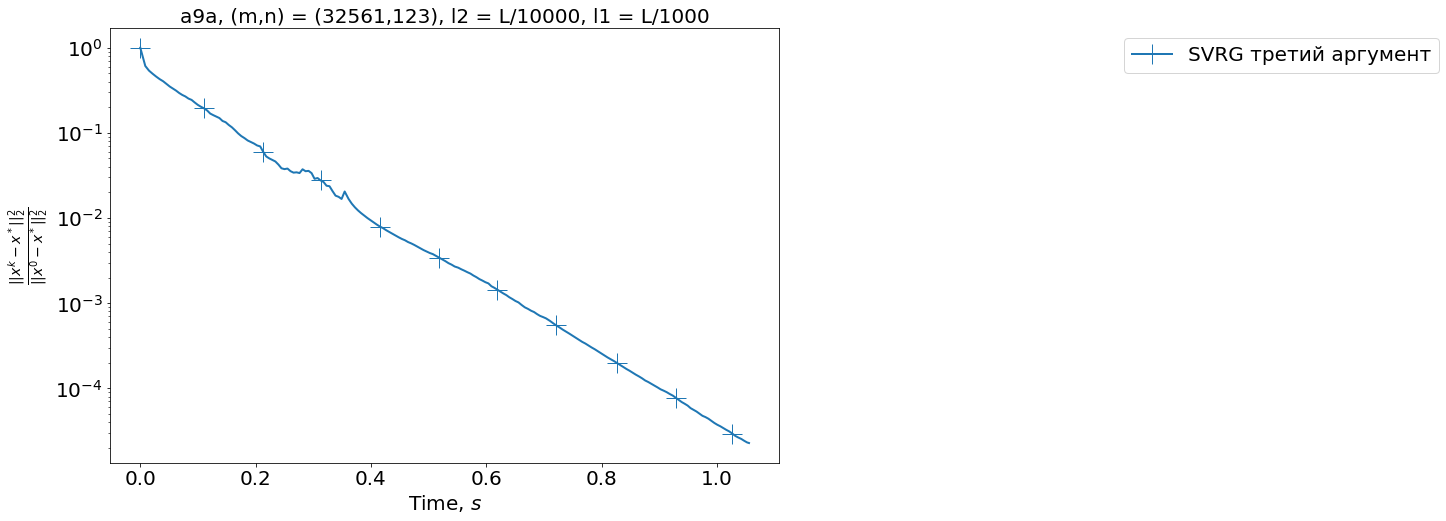

In [198]:
make_plots(args=args_for_plots)

Попробуйте разные размеры батчей и разные $l_2$ и $l_1$, как это указано в задании

In [199]:
l1s = [L / 1000, L / 10000, L / 100, 0]
batch_sizes = [1, 10, 100]

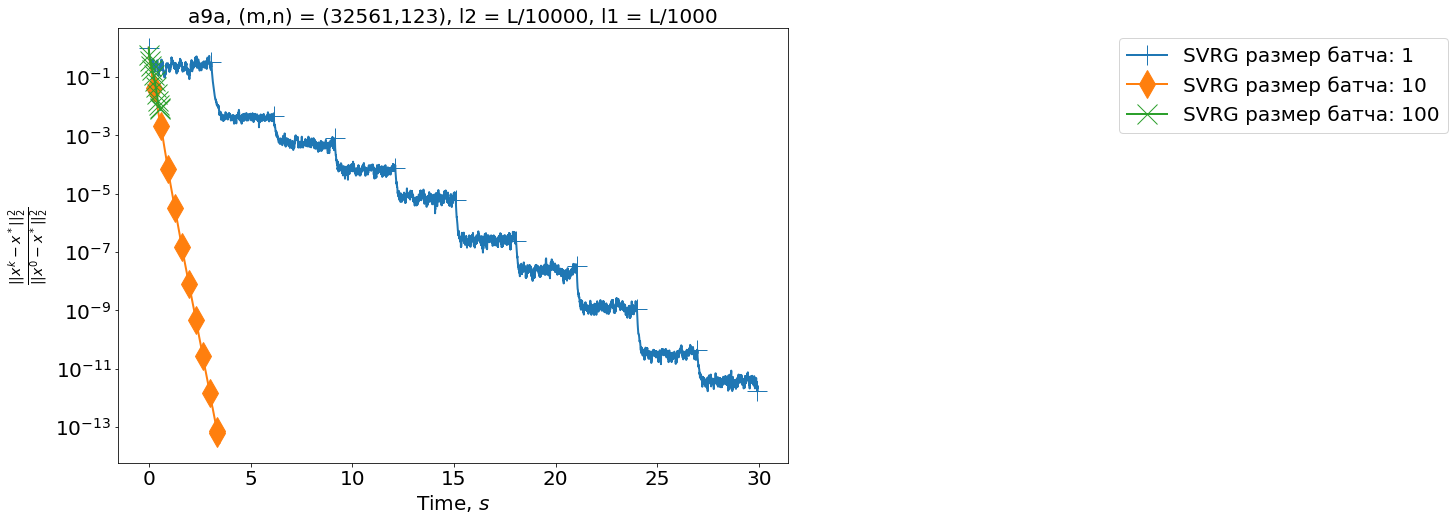

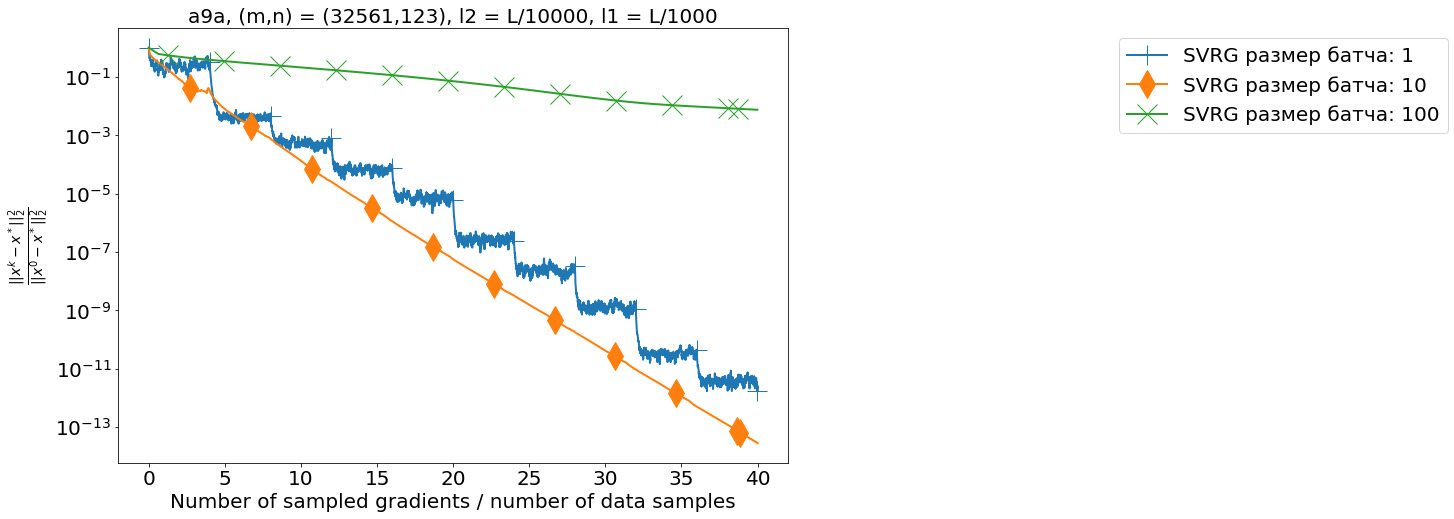

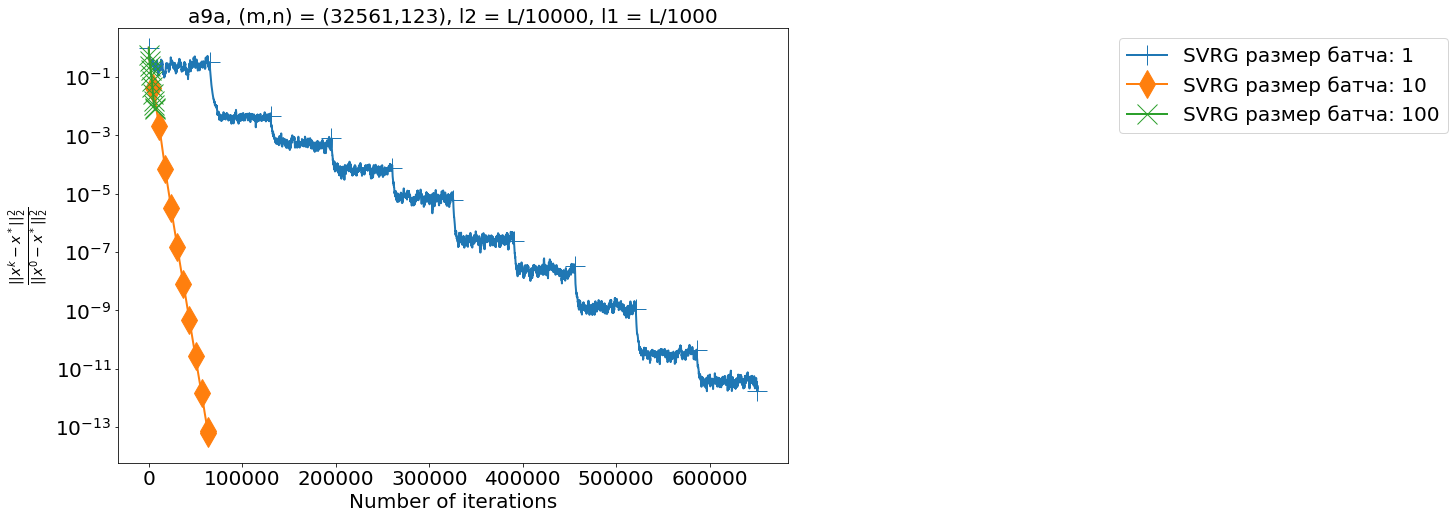

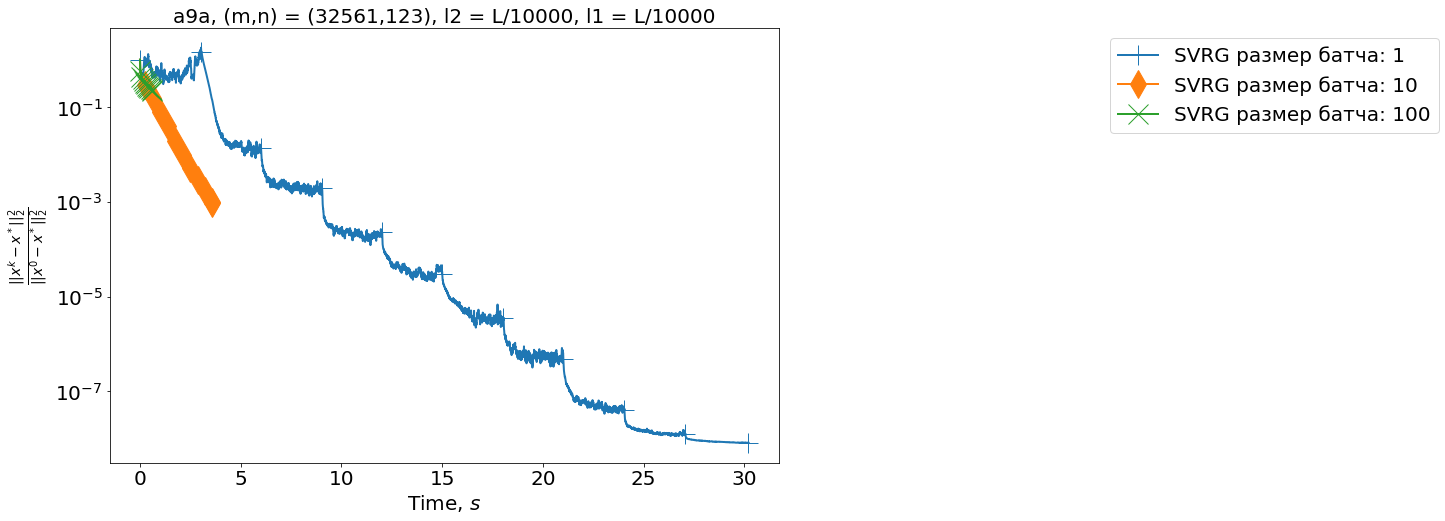

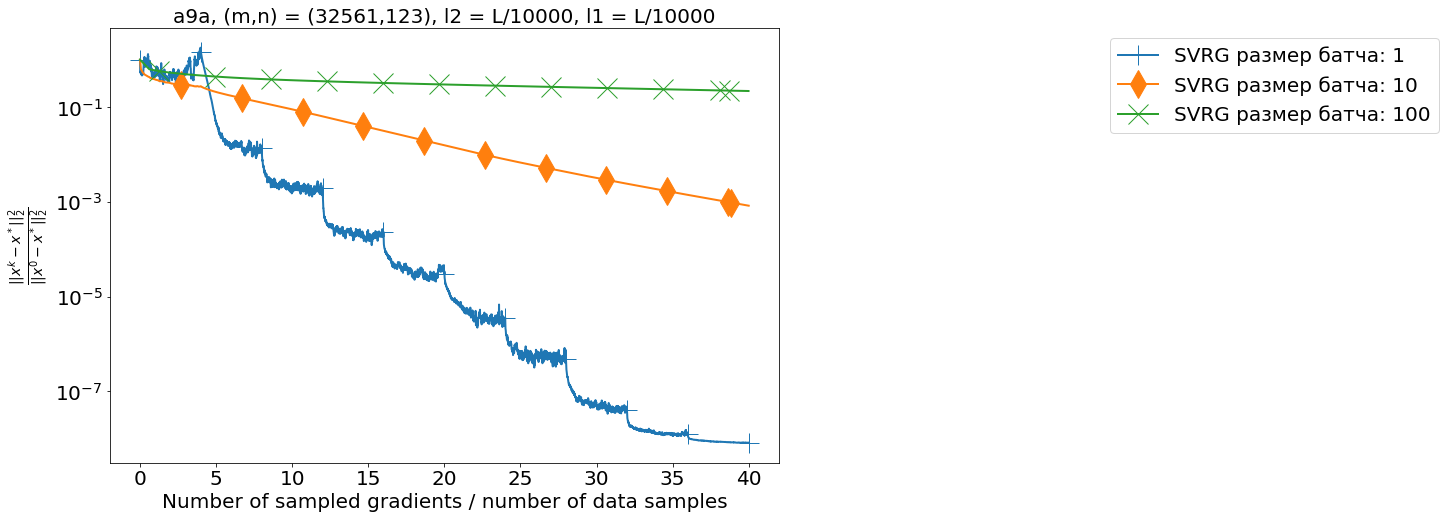

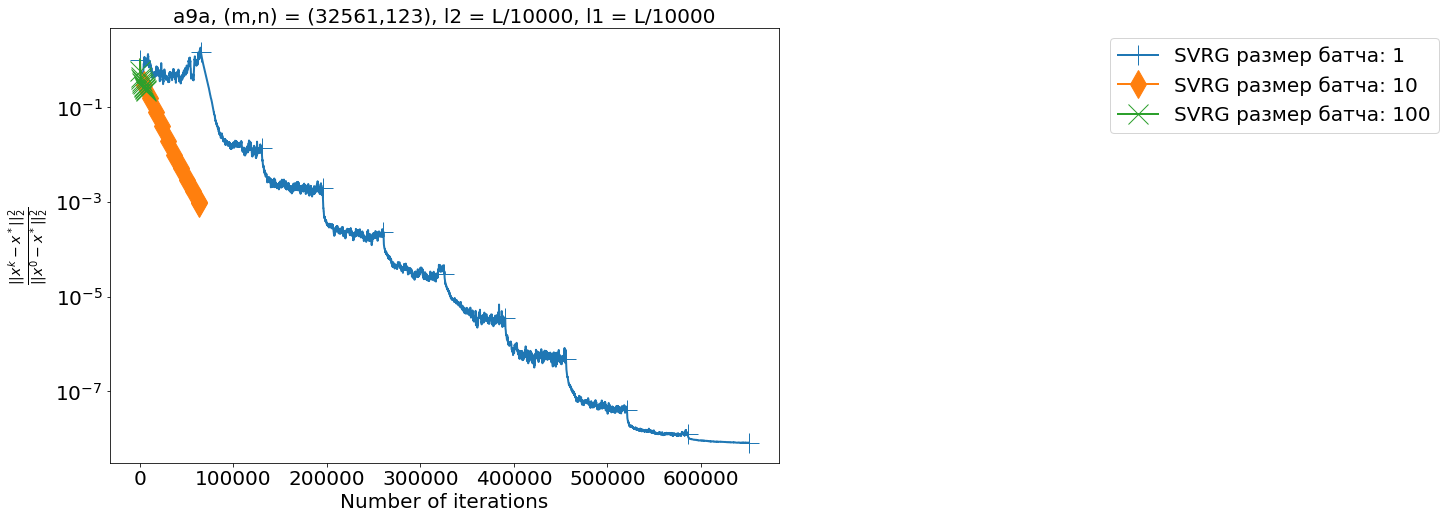

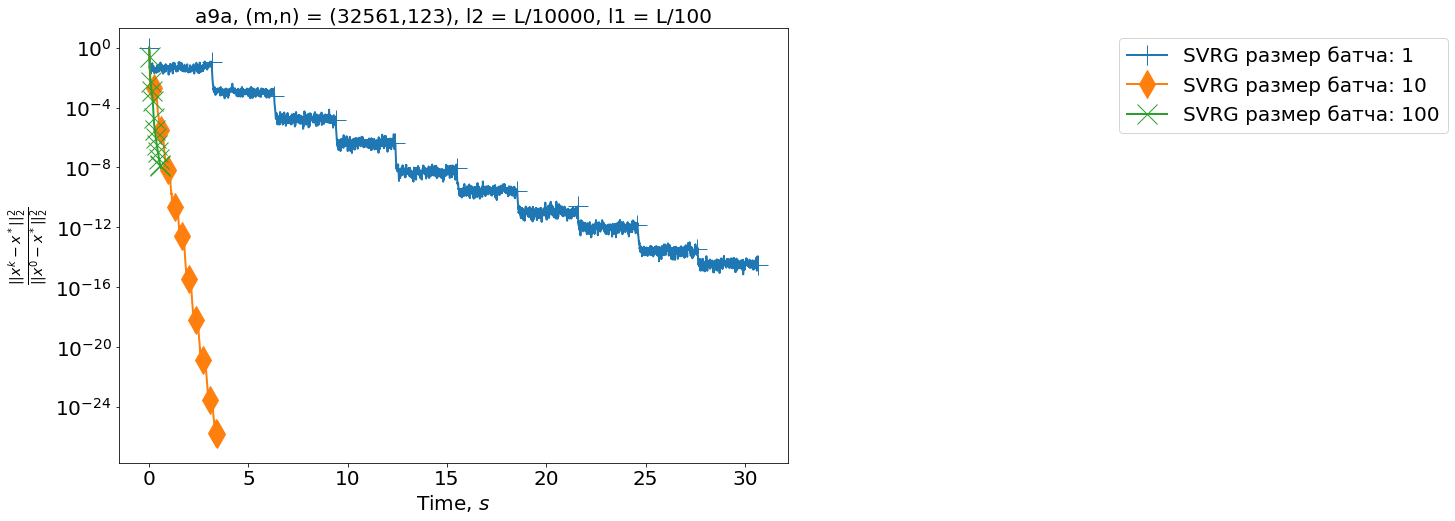

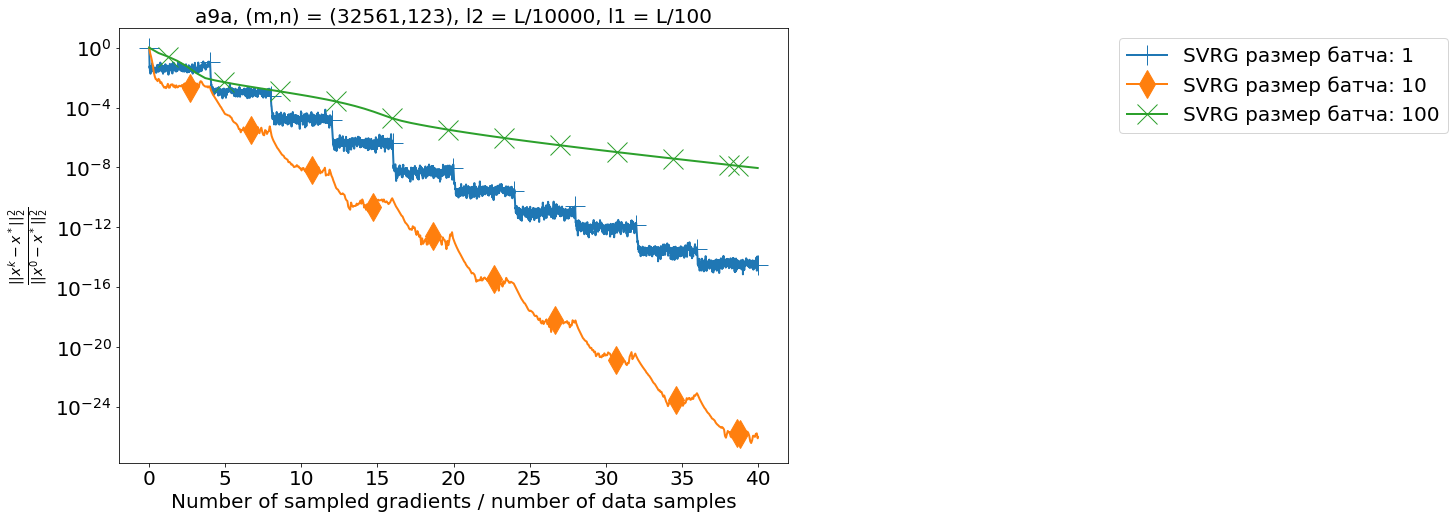

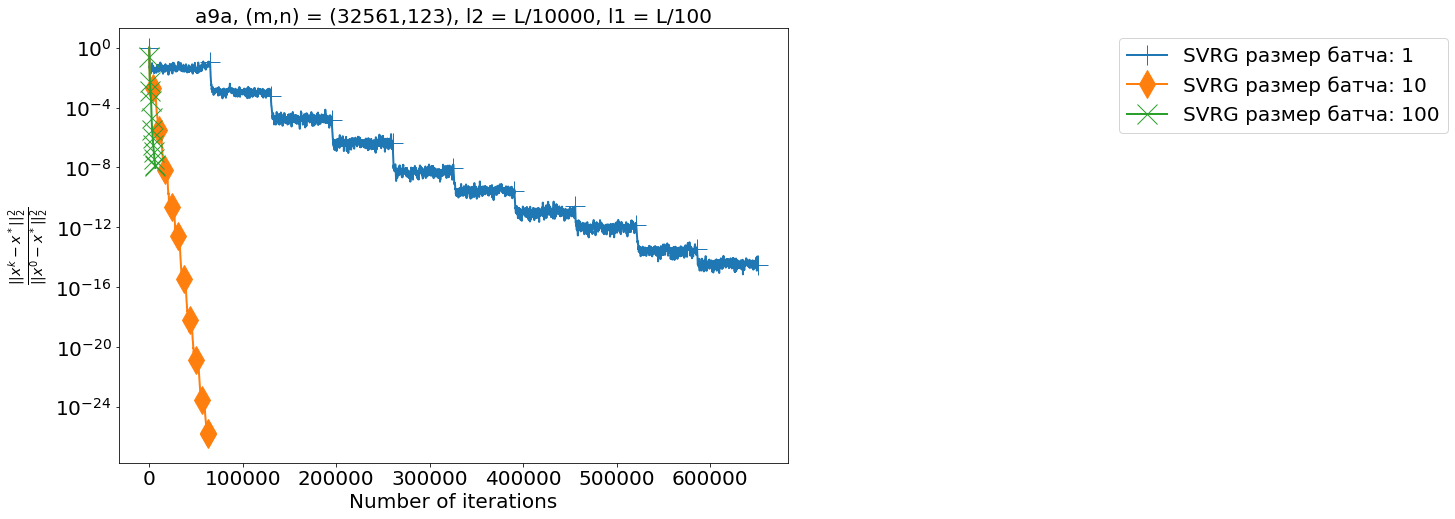

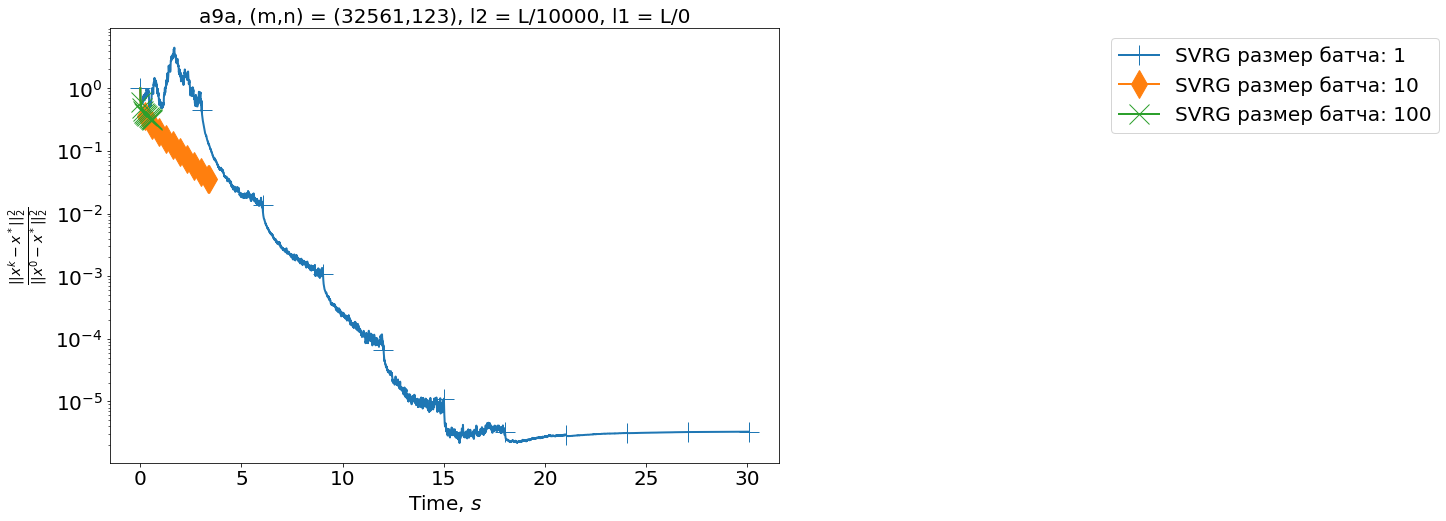

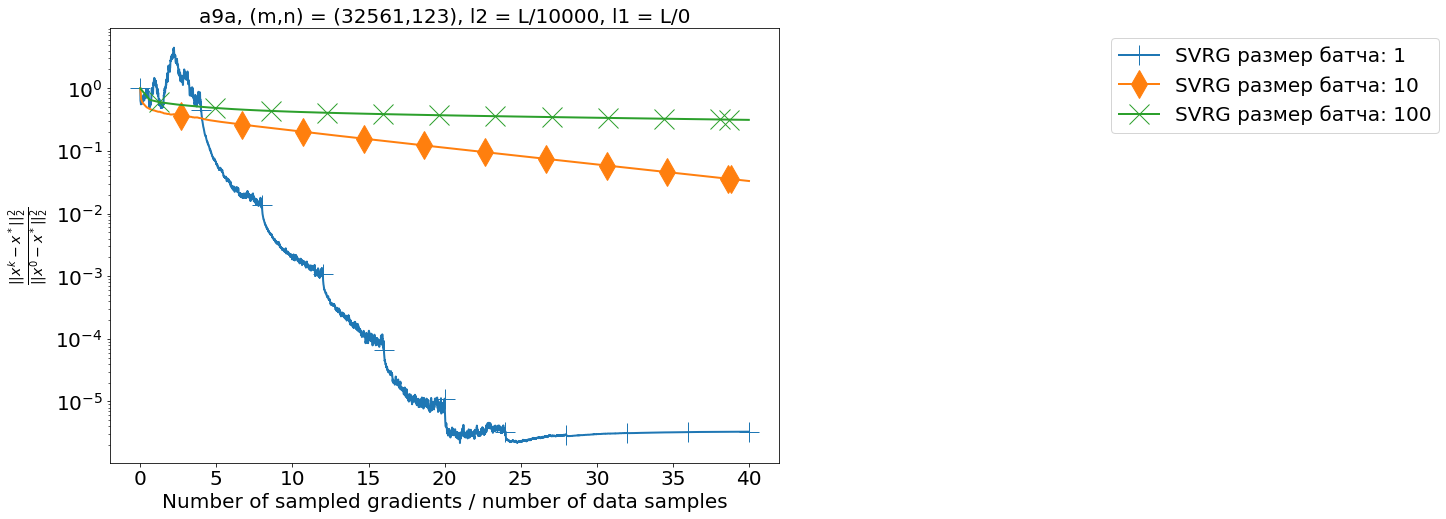

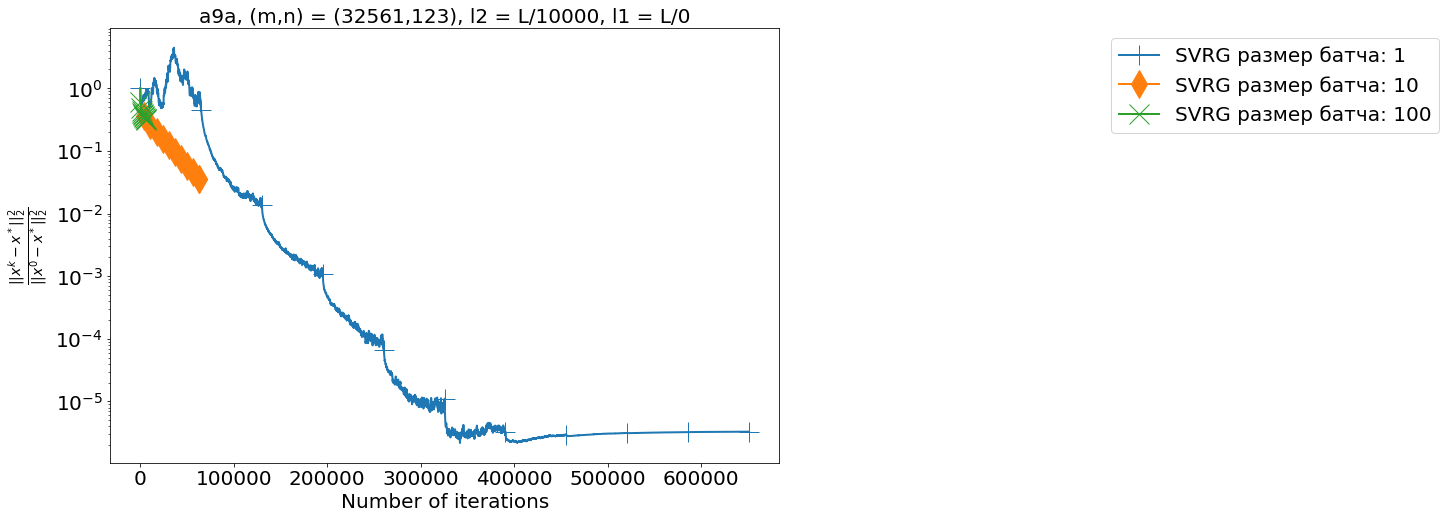

In [203]:
dataset = "a9a"
filename=dataset+"_x_init_all_ones"
l2 = L / 10000
save_info_period = 100
S = 10
mode_y = 'squared_distances'
mode_xs = ['time', 'data_passes', 'iters']
for l1 in l1s:
    methods = []
    param = [A, y, l2, True, l1]
    x_star = read_solution(dataset, l2, l1)[0]
    f_star = read_solution(dataset, l2, l1)[1]
    for batch_size in batch_sizes:
        x_init = np.ones(n)
        M = int(2*m/batch_size)
        gamma = 1.0/(6*(L+l2))
        res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
             sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
             l1=l1, S=S, M=M, max_t=np.inf,
             batch_size=batch_size, indices=None, save_info_period=save_info_period, 
             x_star=x_star, f_star=f_star)
        methods.append(['SVRG', [gamma, l2, l1, S, M, batch_size], 
                        f' размер батча: {batch_size}', None])
    for mode_x in mode_xs:
        title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1) if l1 else 0)
        args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
        make_plots(args=args_for_plots)
        plt.show()

1. Для какого размера батча метод сходится быстрее по числу итераций? - Средний
2. По числу эпох? - Наименьший
3. По затраченному времени? - Средний

## Задание 4. SGD

Имплементируйте $\texttt{prox-SGD}$ с мини-батчингом и постоянным шагом. Имплементируйте $\texttt{prox-SGD}$ с мини-батчингом и периодически уменьшающимся шагом.

In [204]:
with open("dump/test_indices_a9a.txt", 'rb') as file:
    test_indices = pickle.load(file)

filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
x_star = None
f_star = None
S = 3
save_info_period = 100

In [205]:
%%time
res = sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 404 ms, sys: 1.64 ms, total: 406 ms
Wall time: 406 ms


Запустите функцию, тестирующую корректность работы

In [206]:
sgd_const_test(res)

Тесты пройдены!


0

In [207]:
with open("dump/test_indices_a9a.txt", 'rb') as file:
    test_indices = pickle.load(file)

filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
gamma_schedule = [gamma, 1, 0.5]
x_star = None
f_star = None
S = 10
save_info_period = 100

In [208]:
%%time
res = sgd_decr_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma_schedule=gamma_schedule, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 1.35 s, sys: 3.89 ms, total: 1.35 s
Wall time: 1.35 s


Запустите функцию, тестирующую корректность работы

In [209]:
sgd_decr_test(res)

Тесты пройдены!


0

Если тесты пройдены успешно, то выполните эксперименты, описанные в задании.

In [210]:
alphas = [1, 0.1, 0.01]
batch_sizes = [1, 10, 100]

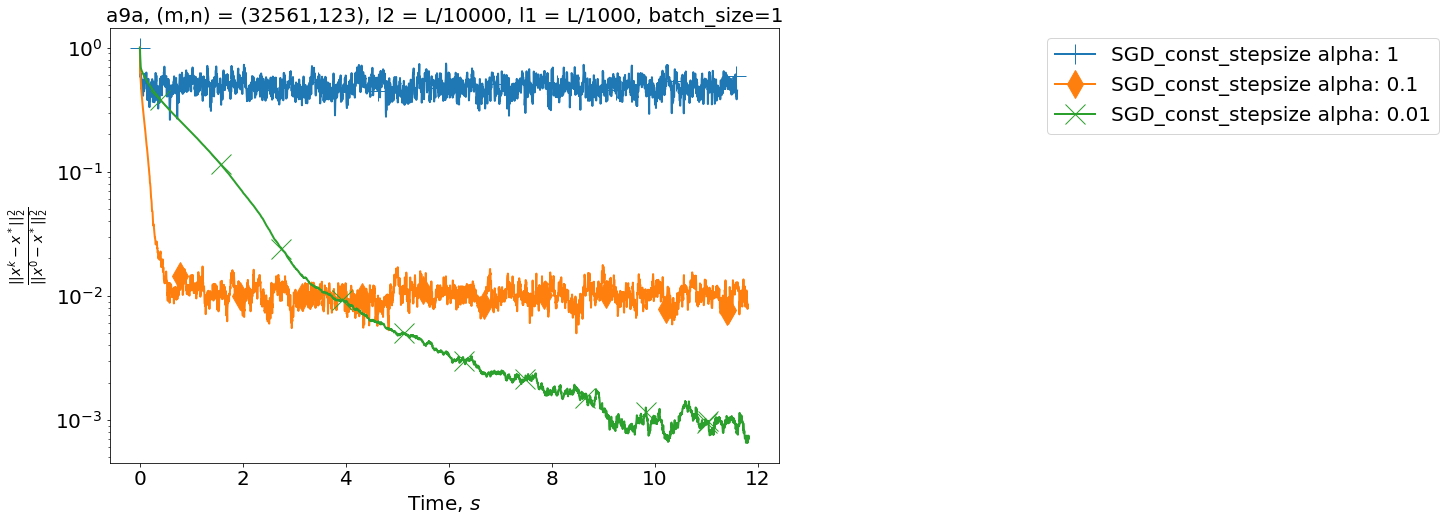

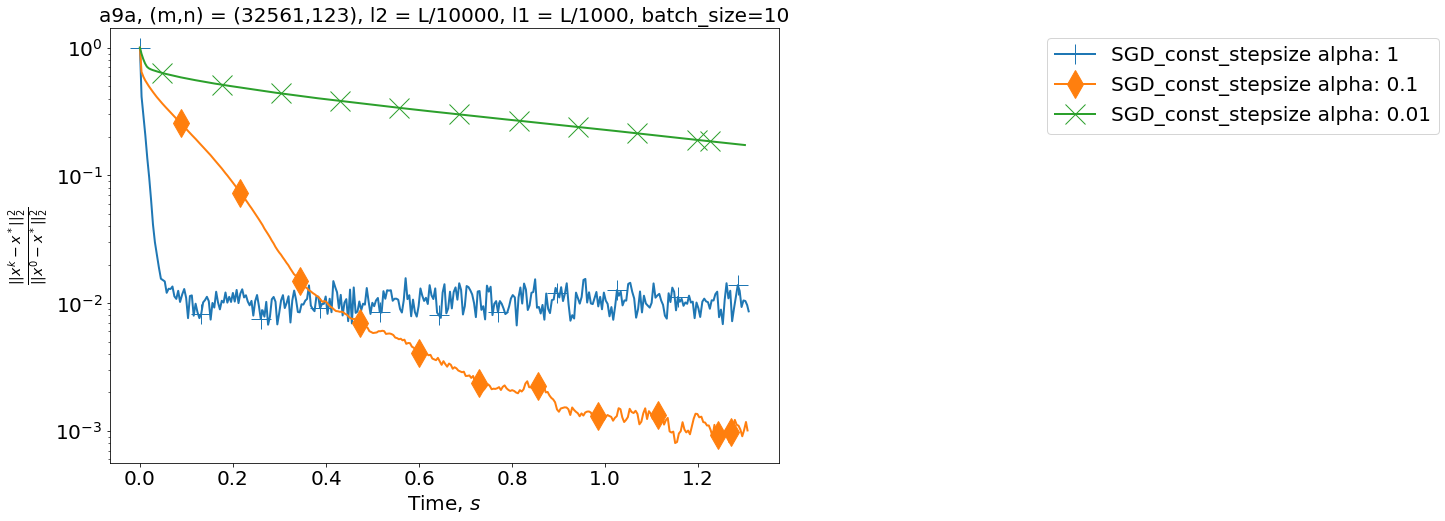

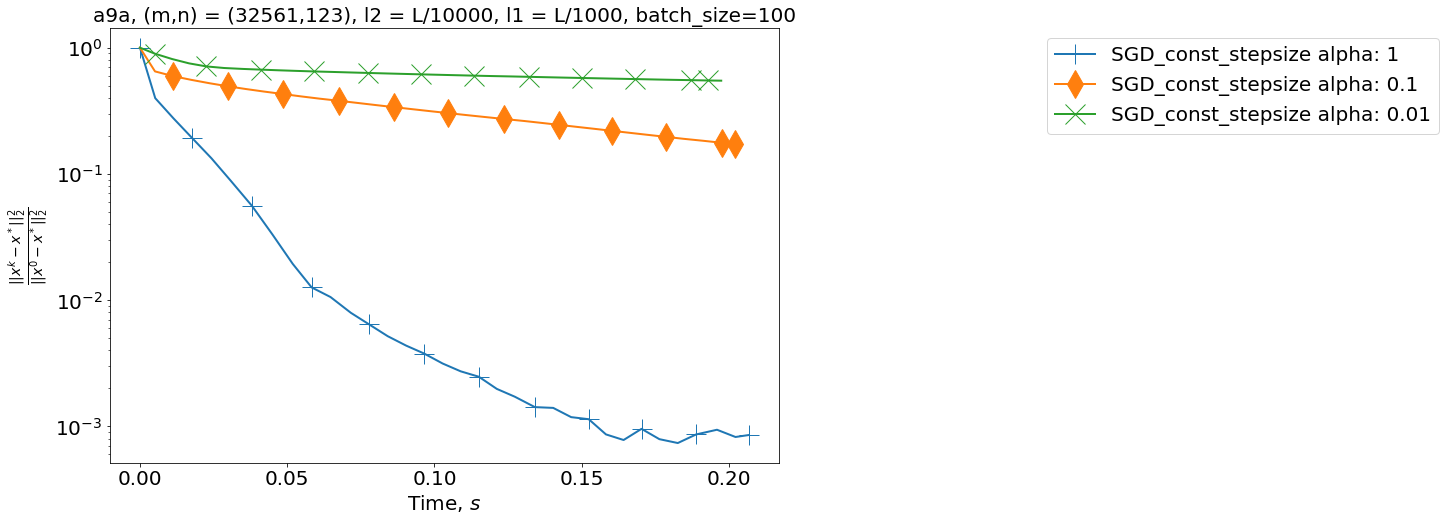

In [212]:
dataset = "a9a"
filename=dataset+"_x_init_all_ones"
l2 = L / 10000
l1 = L / 1000
save_info_period = 100
S = 10
x_init = np.ones(n)
mode_y = 'squared_distances'
mode_xs = ['time']
x_star = read_solution(dataset, l2, l1)[0]
f_star = read_solution(dataset, l2, l1)[1]
for batch_size in batch_sizes:
    methods = []
    M = int(2*m/batch_size)
    for alpha in alphas:
        gamma = alpha/(L+l2)
        res = sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
             sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
             l1=l1, S=S, max_t=np.inf,
             batch_size=batch_size, indices=None, save_info_period=save_info_period, 
             x_star=x_star, f_star=f_star)
        methods.append(['SGD_const_stepsize', [gamma, l2, l1, S, batch_size], 
                        f' alpha: {alpha}', None])
    for mode_x in mode_xs:
        title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1)) + ", batch_size=" + str(batch_size)
        args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
        make_plots(args=args_for_plots)
        plt.show()

1. Какое α лучше выбирать? - Чем меньше, тем точнее результат, но ждать придется долго
2. Зависит ли ответ от желаемой точности? - да
3. Зависит ли ответ от r? - да, чем больше батч, тем тем дольше ждать при маленьких α

In [213]:
ts = [1, 2]
bs = [0.5, 0.9]
batch_sizes = [1, 10, 100]

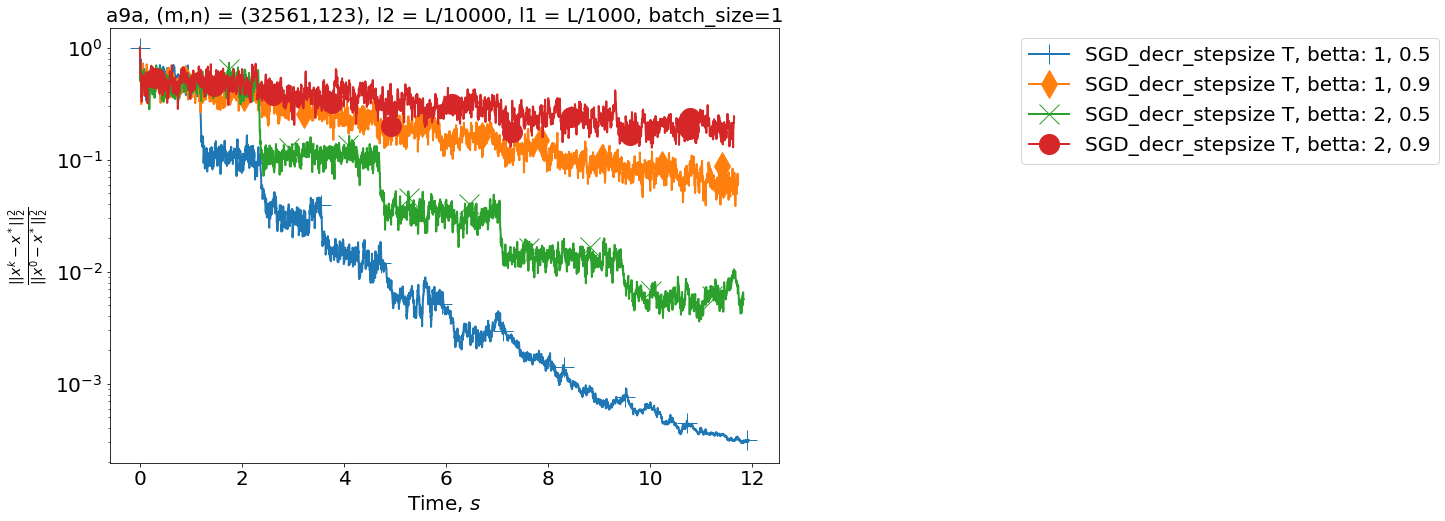

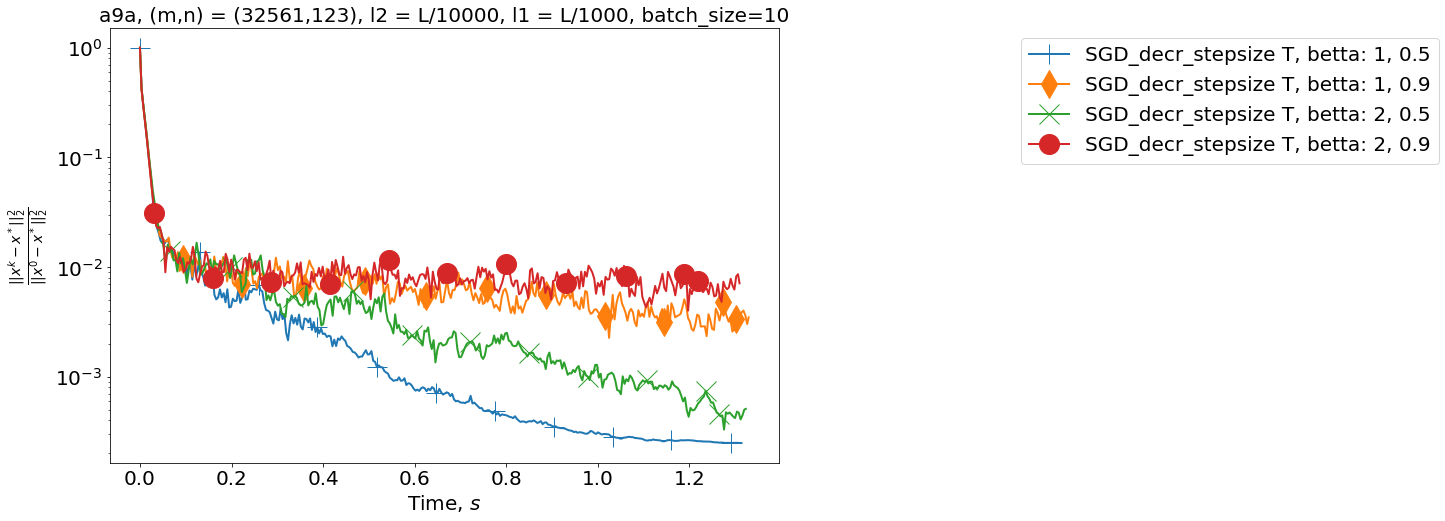

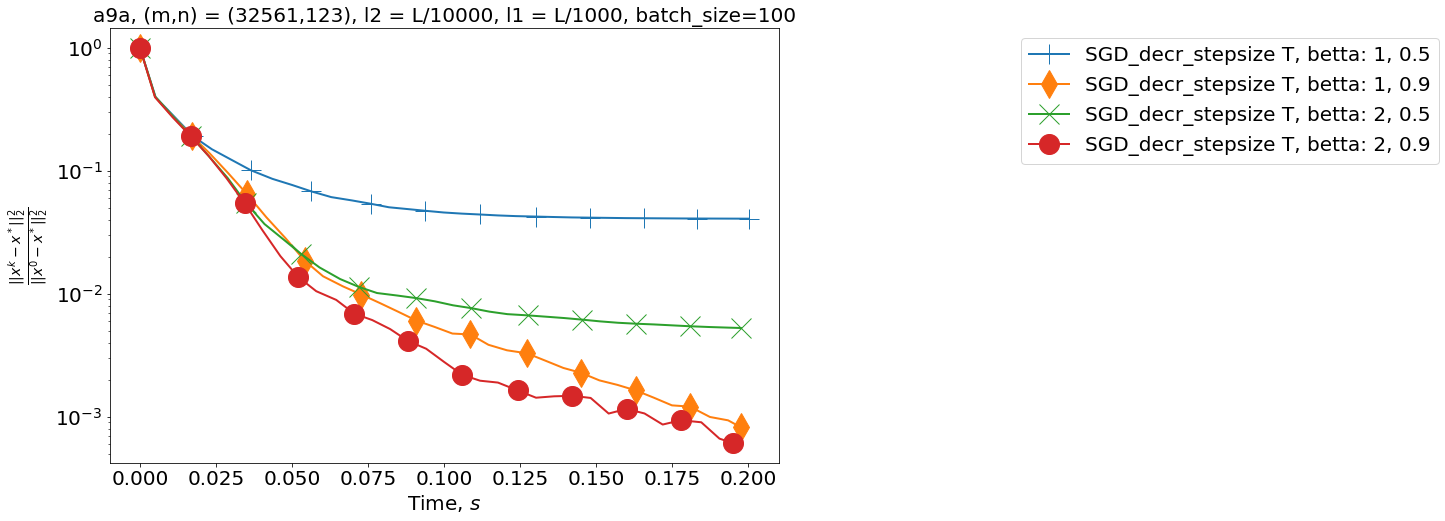

In [214]:
dataset = "a9a"
filename=dataset+"_x_init_all_ones"
l2 = L / 10000
l1 = L / 1000
save_info_period = 100
S = 10
x_init = np.ones(n)
gamma = 1.0/(L+l2)
mode_y = 'squared_distances'
mode_xs = ['time']
x_star = read_solution(dataset, l2, l1)[0]
f_star = read_solution(dataset, l2, l1)[1]
for batch_size in batch_sizes:
    methods = []
    M = int(2*m/batch_size)
    for t in ts:
        for b in bs:
            gamma_schedule = [gamma, t, b]
            res = sgd_decr_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma_schedule=gamma_schedule, l2=l2, 
                 sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
                 l1=l1, S=S, max_t=np.inf,
                 batch_size=batch_size, indices=None, save_info_period=save_info_period, 
                 x_star=x_star, f_star=f_star)
            methods.append(['SGD_decr_stepsize', [gamma_schedule, l2, l1, S, batch_size], 
                            f' T, betta: {t}, {b}', None])
    for mode_x in mode_xs:
        title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1)) + ", batch_size=" + str(batch_size)
        args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
        make_plots(args=args_for_plots)
        plt.show()

1. Какая политика выбора шага лучше? - Самый быстрый но не точный: T и betta меньше, если нужно точнее увеличивать betta
2. Зависит ли ответ от желаемой точности? - да
3. Зависит ли ответ от r? - да, с увеличением батча нужно увеличивать betta

## Задание 5. prox-GD, FISTA и GD

Имплементируйте $\texttt{prox-GD}$, $\texttt{FISTA}$ и $\texttt{GD}$

In [237]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
gamma = 1.0/((L+l2))
x_star = read_solution(dataset, l2,l1)[0]
f_star = None
S = 1000
save_info_period = 10

#этото параметр выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse = False

In [238]:
%%time
res = prox_gd(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 2.14 s, sys: 8.72 ms, total: 2.15 s
Wall time: 2.15 s


In [239]:
R = res['squared_distances'][0]
delta_f = res['func_vals'][0] - read_solution(dataset, l2,l1)[1]

In [240]:
R

142.0815692054481

Запустите функцию, тестирующую корректность работы

In [241]:
prox_gd_test(res)

Тесты пройдены!


0

In [242]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
S = 1000
save_info_period = 10

In [243]:
%%time
res = FISTA(filename=filename, x_init=x_init, A=A, y=y, L=L+l2, mu=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 2.17 s, sys: 5.24 ms, total: 2.17 s
Wall time: 2.17 s


Запустите функцию, тестирующую корректность работы

In [244]:
fista_test(res)

Тесты пройдены!


0

In [247]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
gamma = 1.0/((L+l2))
S = 1000
save_info_period = 10

In [248]:
%%time
res = gd(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 2.4 s, sys: 7.8 ms, total: 2.41 s
Wall time: 2.41 s


Запустите функцию, тестирующую корректность работы

In [249]:
gd_test(res)

Тесты пройдены!


0

Если тесты пройдены успешно, то выполните эксперименты, описанные в задании.

In [250]:
l2 = L / 10000
l1 = L / 1000
epsilon=10**-8
x_init = np.ones(n)
filename=dataset+"_x_init_all_ones"
save_info_period = 100

In [251]:
S=int(np.sqrt(L/l2)*np.log((delta_f+l2*R)/epsilon))
res = FISTA(filename=filename, x_init=x_init, A=A, y=y, L=L, mu=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

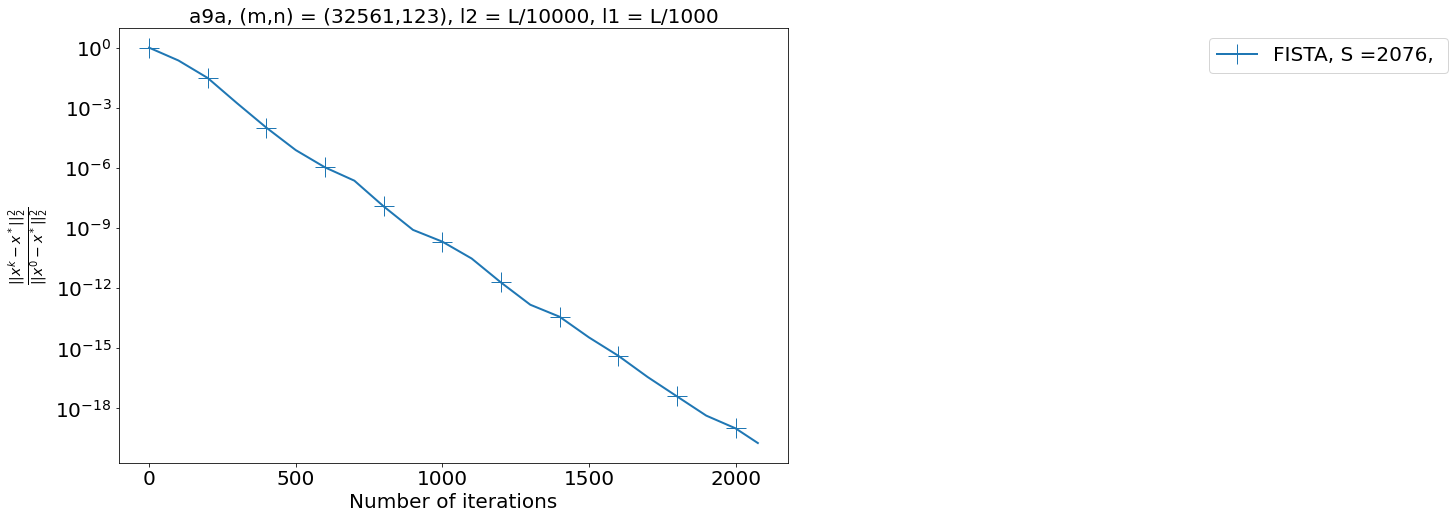

In [252]:
methods = [
         ['FISTA', [l2, l1, S], 
           f', S ={S}, ', None],
]
mode_y = 'squared_distances'
mode_x = 'iters'
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

In [253]:
gamma = 1/L
S=min(int((L/l2)*np.log(R ** 2 / epsilon)), 10000)
res = prox_gd(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

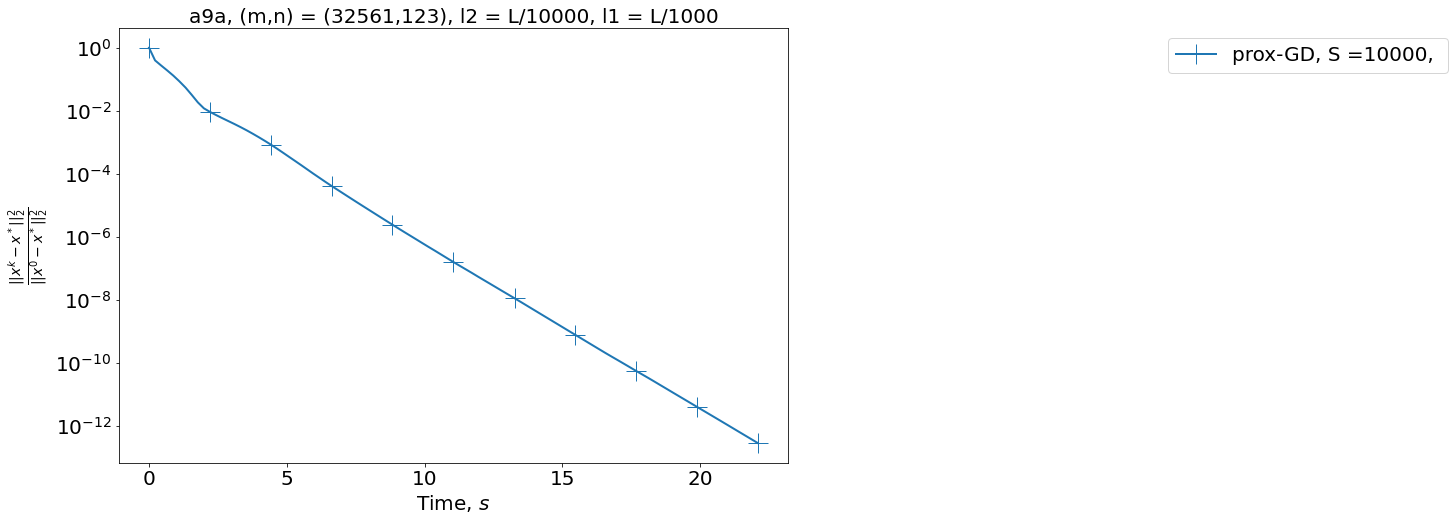

In [254]:
methods = [
         ['prox-GD', [gamma, l2, l1,S], 
           f', S ={S}, ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

In [255]:
alphas = [1, 0.1, 0.01]
S = min(l2 ** 2 * R ** 2 / epsilon ** 2, 10000)

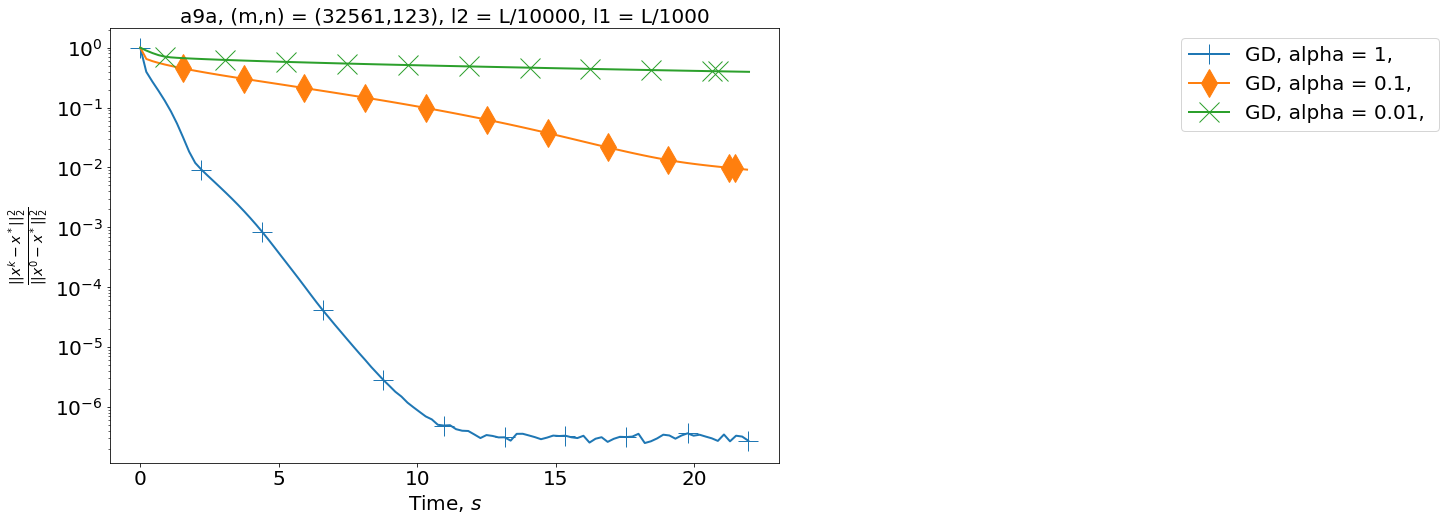

In [256]:
methods = []
mode_y = 'squared_distances'
mode_x = 'time'
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))
for alpha in alphas:
    gamma = alpha / (L + l2)
    res = gd(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
         sparse=sparse, l1=l1, S=S, max_t=np.inf,
         save_info_period=save_info_period, 
         x_star=x_star, f_star=f_star)
    methods.append(
             ['GD', [gamma,l2, l1, S], 
               f', alpha = {alpha}, ', None])

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

## Задание 6. Сравнение методов

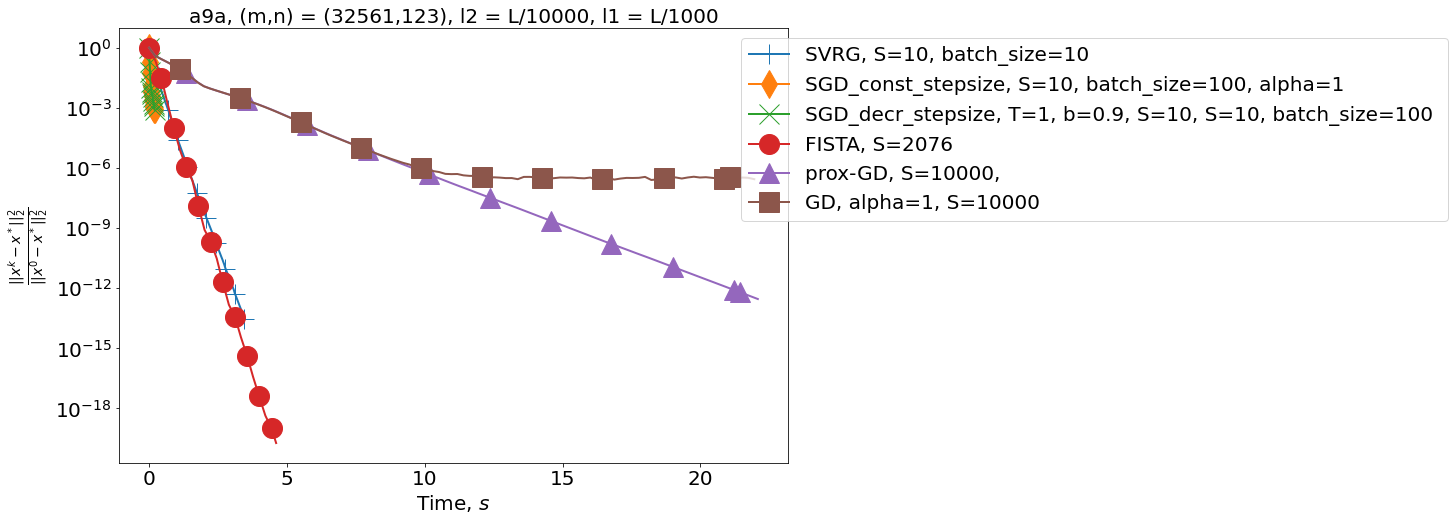

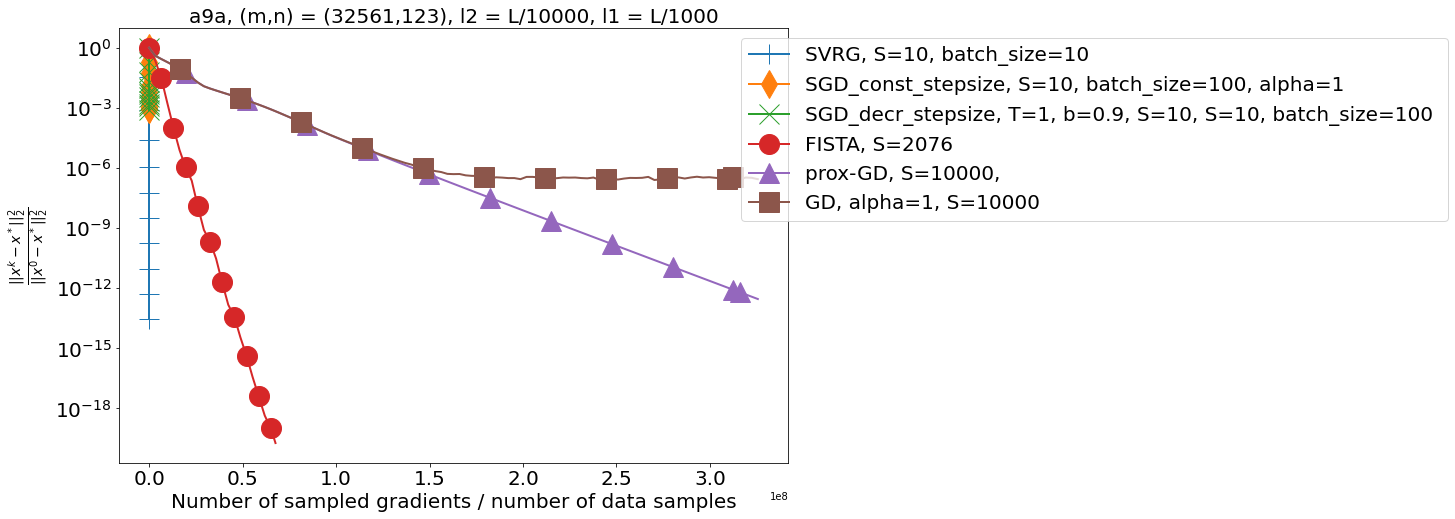

In [347]:
dataset = "a9a"
filename=dataset+"_x_init_all_ones"
l2 = L / 10000
l1 = L / 1000
methods = [
    ['SVRG', [1.0/(6*(L+l2)), l2, l1, 10, int(2*m/10), 10], f', S=10, batch_size=10', None],
    ['SGD_const_stepsize', [1/(L+l2), l2, l1, 10, 100], f', S=10, batch_size=100, alpha=1', None],
    ['SGD_decr_stepsize', [[1/(L+l2), 1, 0.9], l2, l1, 10, 100], f', T=1, b=0.9, S=10, S=10, batch_size=100 ', None],
    ['FISTA', [l2, l1, 2076], f', S=2076 ', None],
    ['prox-GD', [1/L, l2, l1, 10000], f', S=10000, ', None],
    ['GD', [1/(L+l2),l2, l1, 10000], f', alpha=1, S=10000 ', None]
]
mode_y = 'squared_distances'
mode_xs = ['time', 'data_passes']
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

for mode_x in mode_xs:
    args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
    make_plots(args=args_for_plots)
    plt.show()

1. Если нужно быстро к окрестности - SGD, const stepsize или decr_stepsize - большой роли не играет
2. Если выбирать между GD или prox GD, то лучше prox
3. SVRG и FISTA примерно одинаковы, FISTA чуть получше

## Задание 7. Эксперименты с другим датасетом

In [348]:
%%time
dataset = "australian"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Число функций в сумме: ", m, ", размерность задачи: ", n)
L, average_L, worst_L = compute_L(dataset, A) #L может   зависеть от запуска, поэтому для каждой задачи нужно сохранить свою константу L
print("Константа гладкости всей функции: ", L)
print("Средняя константа гладкости     : ", average_L)
print("Худшая константа гладкости      : ", worst_L)
print("Доля ненулевых элементов: ", sparsity_A)

Число функций в сумме:  690 , размерность задачи:  14
Константа гладкости всей функции:  7036285.411416825
Средняя константа гладкости     :  7051931.830991588
Худшая константа гладкости      :  2500100840.3125
Доля ненулевых элементов:  0.7995859213250518
CPU times: user 5.36 ms, sys: 1.08 ms, total: 6.43 ms
Wall time: 6.88 ms


In [349]:
# ваш код здесь
# задать параметры
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
x_star = None
f_star = None
S = 10000 # Не могу я ждать
save_info_period = 100

In [320]:
%%time
for l1 in [L / 500000]:
    print(f"L1: {l1}")
    res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
         sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
         l1=l1, S=S, M=M, max_t=np.inf,
         batch_size=batch_size, indices=None, save_info_period=save_info_period, 
         x_star=x_star, f_star=f_star)
    print("Найденное значение: ", res['func_vals'][-1])
    print("Процент ненулевых координат в найденном решении: ", np.count_nonzero(res['last_iter'])/n)
    save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

L1: 14.072570822833649
Найденное значение:  0.6553522655116697
Процент ненулевых координат в найденном решении:  0.14285714285714285
CPU times: user 4min 43s, sys: 1min 27s, total: 6min 11s
Wall time: 38.8 s


In [321]:
param = [A, y, l2, True, L / 500000]
res_solver = minimize(F, x_init, args = param, jac=logreg_grad_plus_lasso, 
                      options={'maxiter':5000, 'disp':True}, tol=1e-10)

print(res_solver.fun)

         Current function value: 0.655352
         Iterations: 139
         Function evaluations: 243
         Gradient evaluations: 243
0.6553522655121767


In [322]:
l1s = [L / 500000]
batch_sizes = [1, 10, 100]

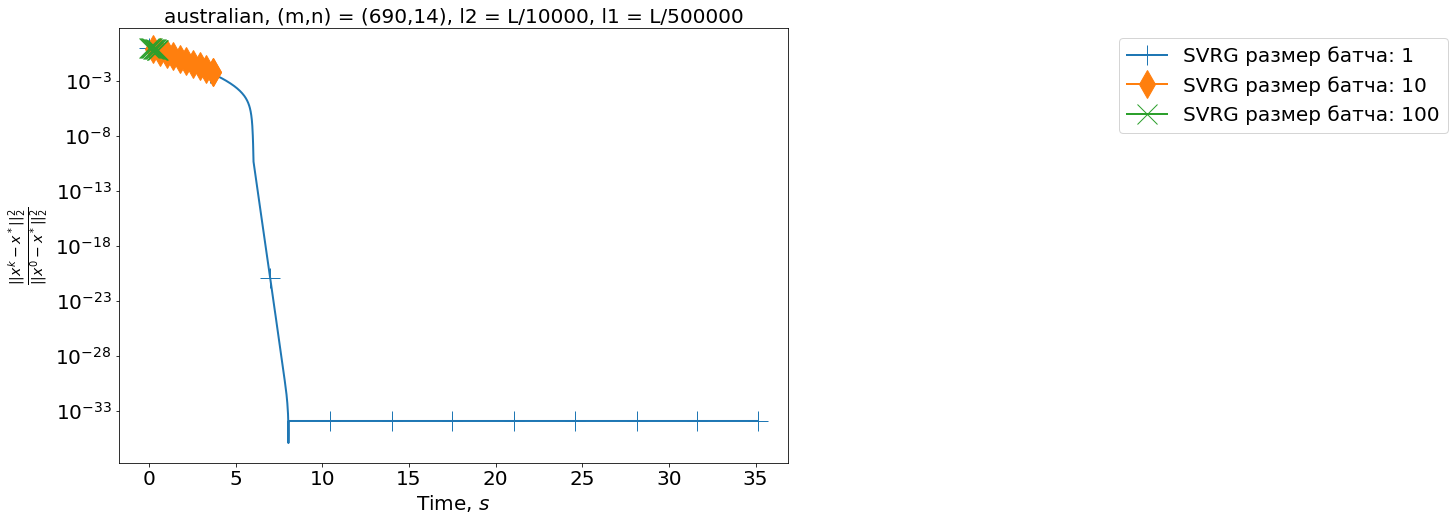

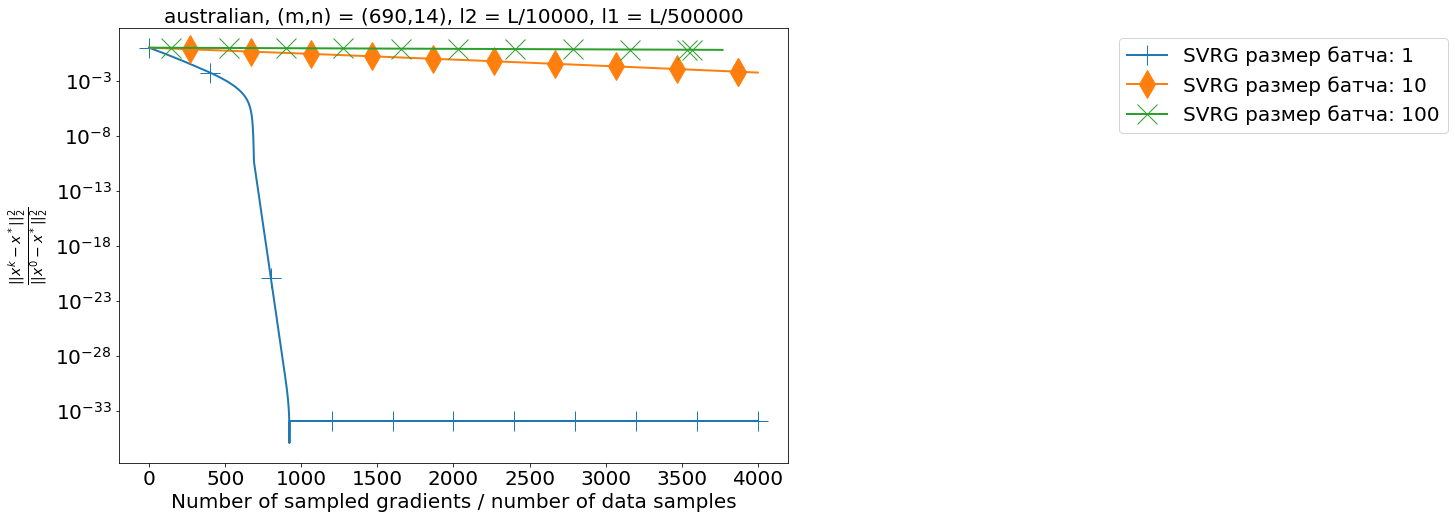

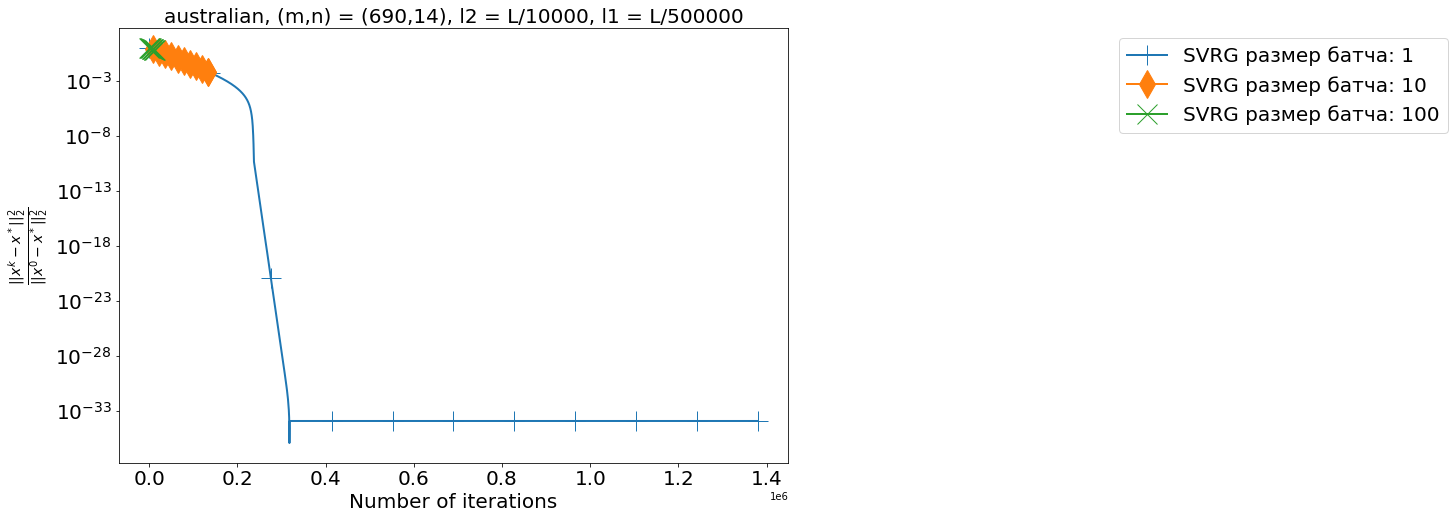

In [323]:
filename=dataset+"_x_init_all_ones"
save_info_period = 100
S = 1000
mode_y = 'squared_distances'
mode_xs = ['time', 'data_passes', 'iters']
for l1 in l1s:
    methods = []
    param = [A, y, l2, True, l1]
    x_star = read_solution(dataset, l2, l1)[0]
    f_star = read_solution(dataset, l2, l1)[1]
    for batch_size in batch_sizes:
        x_init = np.ones(n)
        M = int(2*m/batch_size)
        gamma = 1.0/(6*(L+l2))
        res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
             sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
             l1=l1, S=S, M=M, max_t=np.inf,
             batch_size=batch_size, indices=None, save_info_period=save_info_period, 
             x_star=x_star, f_star=f_star)
        methods.append(['SVRG', [gamma, l2, l1, S, M, batch_size], 
                        f' размер батча: {batch_size}', None])
    for mode_x in mode_xs:
        title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1) if l1 else 0)
        args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
        make_plots(args=args_for_plots)
        plt.show()

In [351]:
alphas = [1, 0.1, 0.01]
batch_sizes = [1, 10, 100]

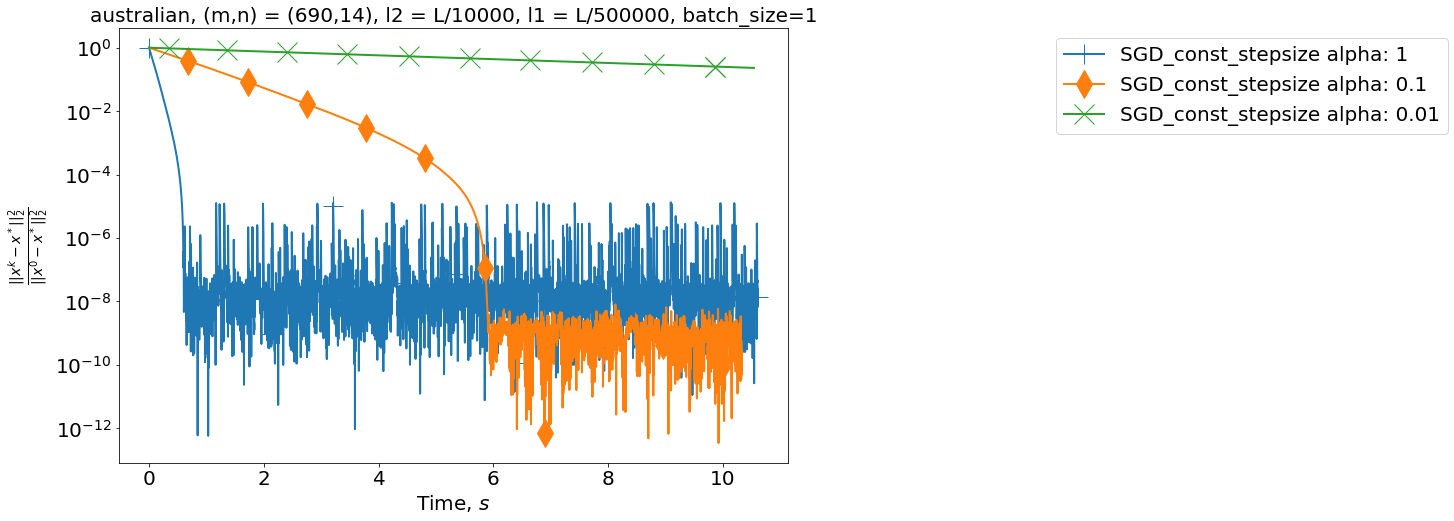

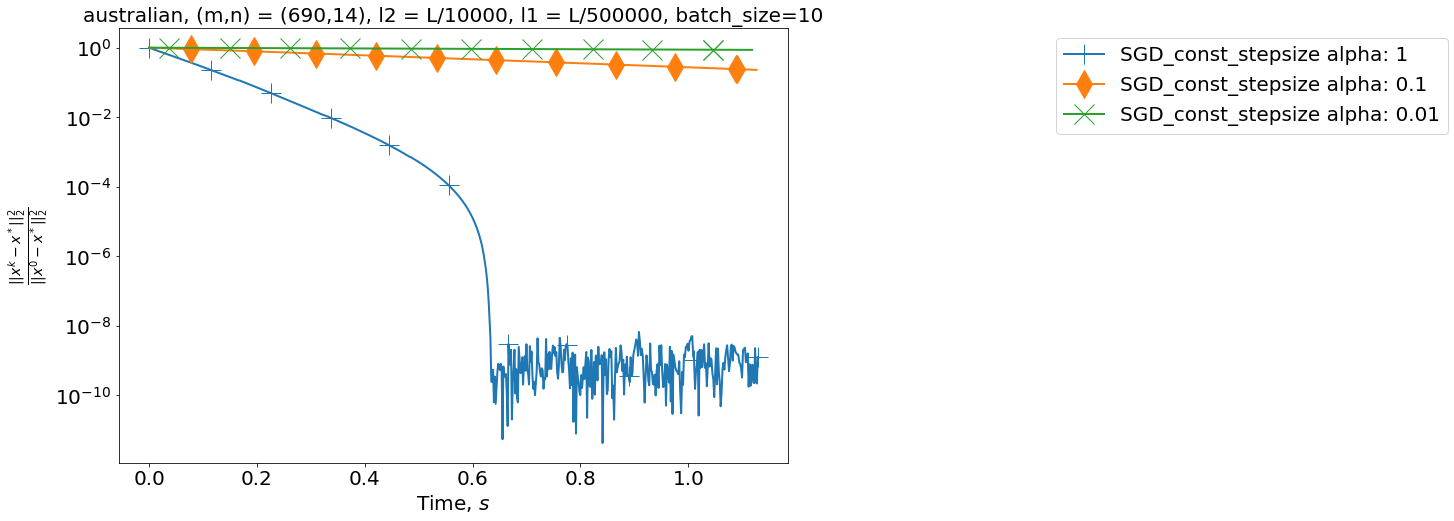

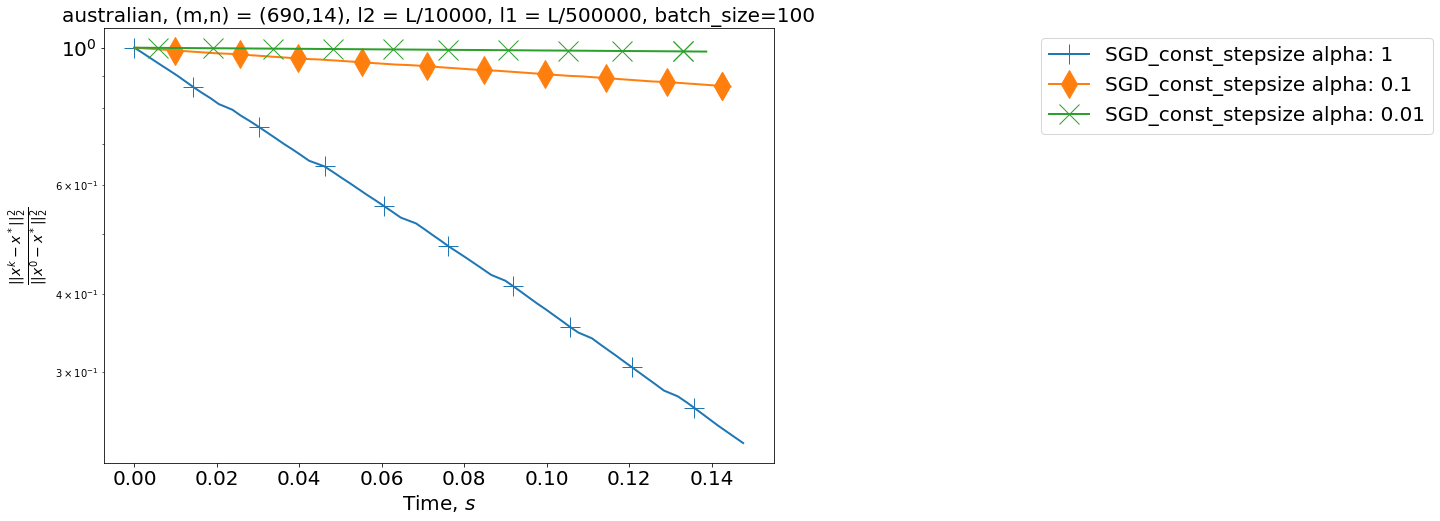

In [352]:
l1 = L / 500000
save_info_period = 100
S = 1000
x_init = np.ones(n)
mode_y = 'squared_distances'
mode_xs = ['time']
x_star = read_solution(dataset, l2, l1)[0]
f_star = read_solution(dataset, l2, l1)[1]
for batch_size in batch_sizes:
    methods = []
    M = int(2*m/batch_size)
    for alpha in alphas:
        gamma = alpha/(L+l2)
        res = sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
             sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
             l1=l1, S=S, max_t=np.inf,
             batch_size=batch_size, indices=None, save_info_period=save_info_period, 
             x_star=x_star, f_star=f_star)
        methods.append(['SGD_const_stepsize', [gamma, l2, l1, S, batch_size], 
                        f' alpha: {alpha}', None])
    for mode_x in mode_xs:
        title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1)) + ", batch_size=" + str(batch_size)
        args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
        make_plots(args=args_for_plots)
        plt.show()

In [333]:
ts = [1, 2, 10]
bs = [0.5, 0.9]
batch_sizes = [1, 10, 100]

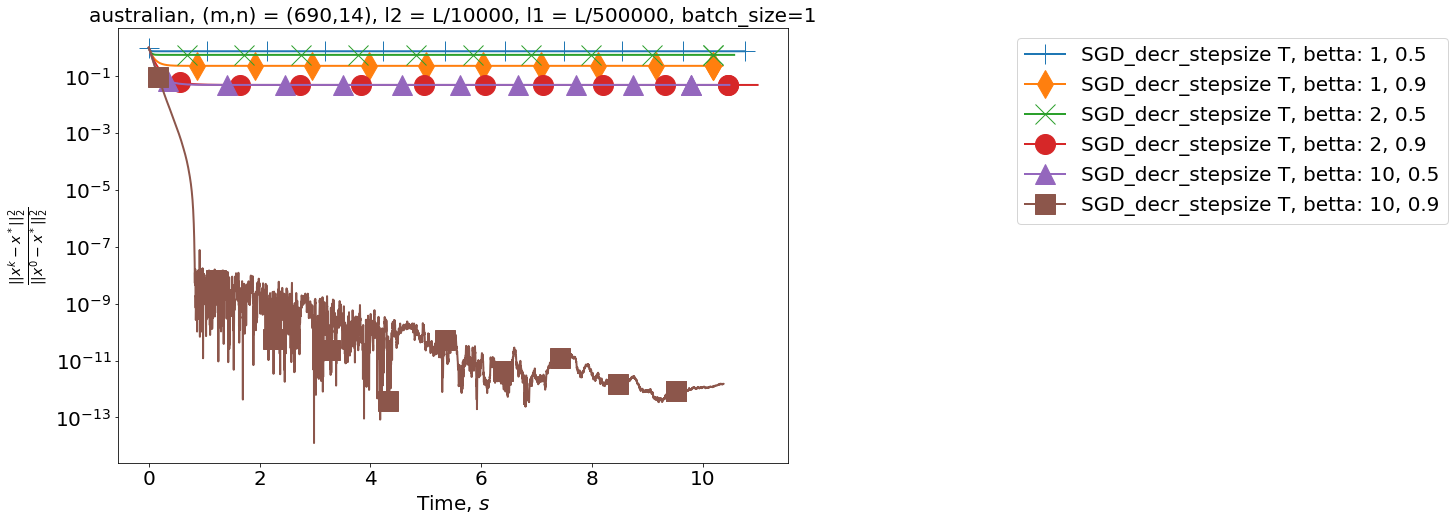

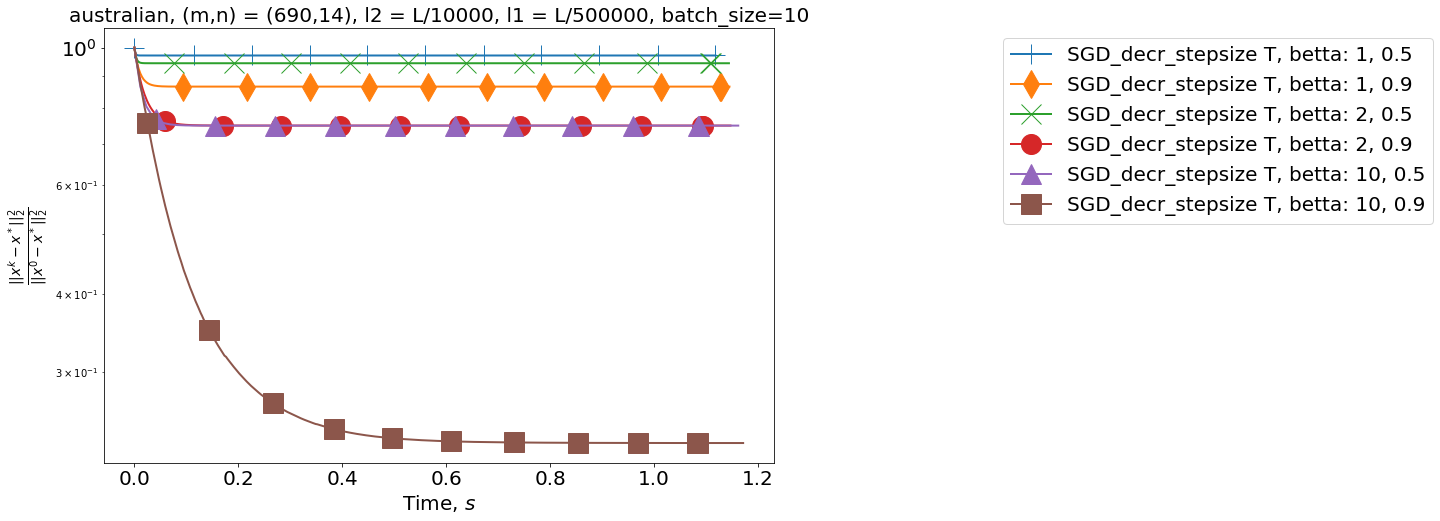

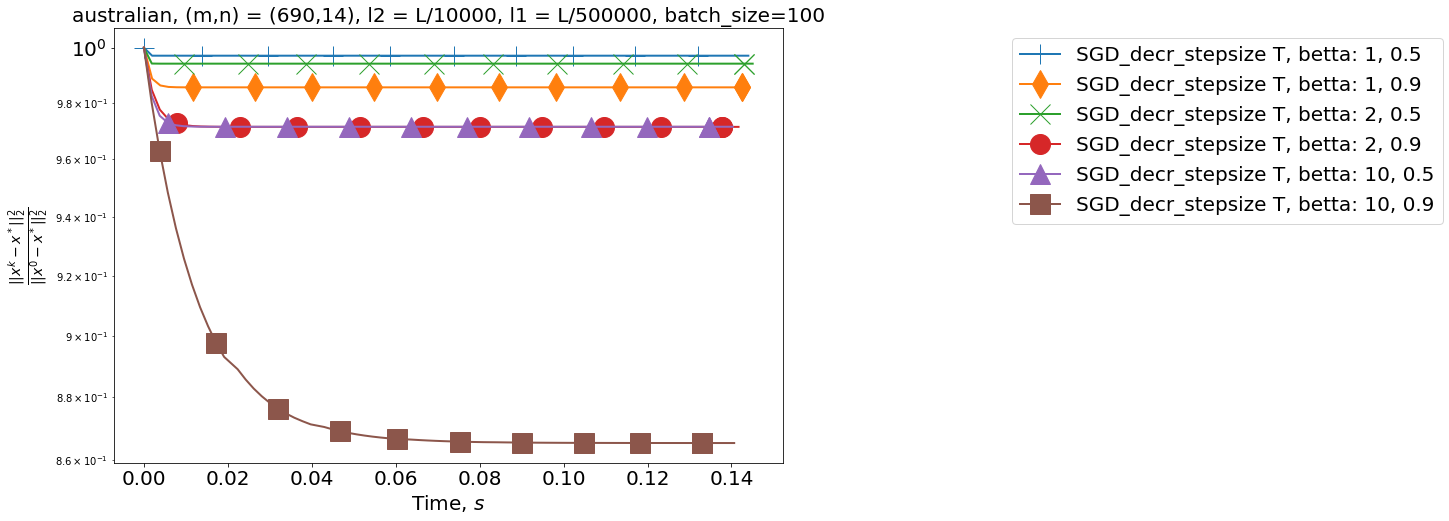

In [334]:
save_info_period = 100
S = 1000
x_init = np.ones(n)
gamma = 1.0/(L+l2)
mode_y = 'squared_distances'
mode_xs = ['time']
x_star = read_solution(dataset, l2, l1)[0]
f_star = read_solution(dataset, l2, l1)[1]
for batch_size in batch_sizes:
    methods = []
    M = int(2*m/batch_size)
    for t in ts:
        for b in bs:
            gamma_schedule = [gamma, t, b]
            res = sgd_decr_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma_schedule=gamma_schedule, l2=l2, 
                 sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
                 l1=l1, S=S, max_t=np.inf,
                 batch_size=batch_size, indices=None, save_info_period=save_info_period, 
                 x_star=x_star, f_star=f_star)
            methods.append(['SGD_decr_stepsize', [gamma_schedule, l2, l1, S, batch_size], 
                            f' T, betta: {t}, {b}', None])
    for mode_x in mode_xs:
        title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1)) + ", batch_size=" + str(batch_size)
        args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
        make_plots(args=args_for_plots)
        plt.show()

In [335]:
R = res['squared_distances'][0]
delta_f = res['func_vals'][0] - read_solution(dataset, l2,l1)[1]

In [336]:
S=int(np.sqrt(L/l2)*np.log((delta_f+l2*R)/epsilon))
res = FISTA(filename=filename, x_init=x_init, A=A, y=y, L=L, mu=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

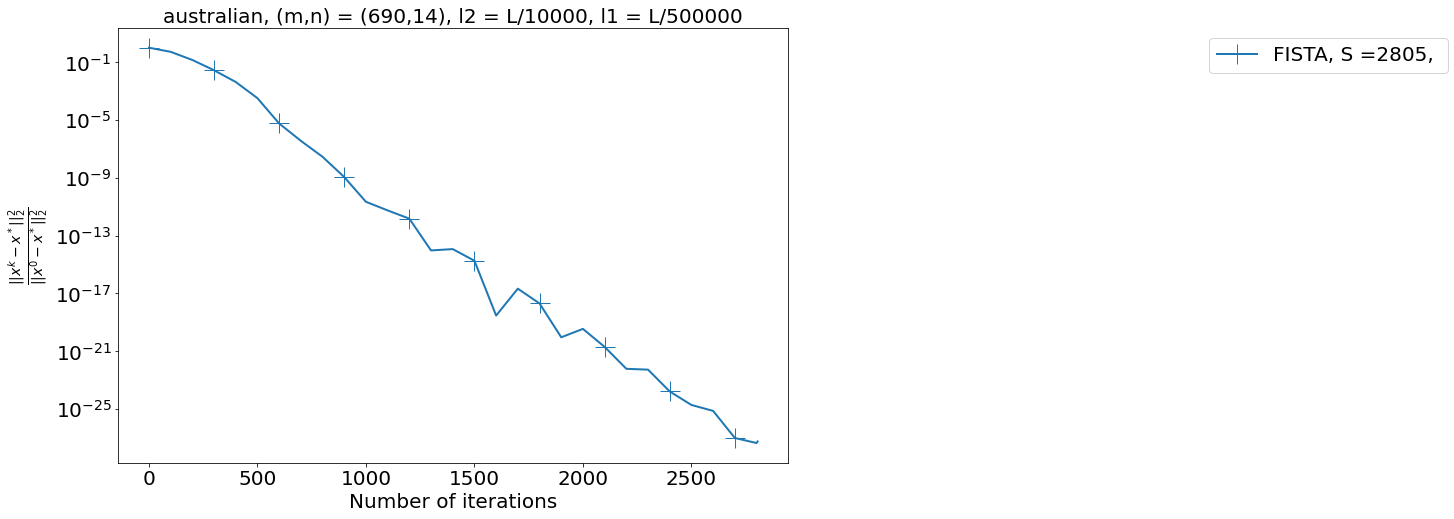

In [337]:
methods = [
         ['FISTA', [l2, l1, S], 
           f', S ={S}, ', None],
]
mode_y = 'squared_distances'
mode_x = 'iters'
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

In [341]:
gamma = 1/L
S=min(int((L/l2)*np.log(R ** 2 / epsilon)), 200000)
res = prox_gd(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

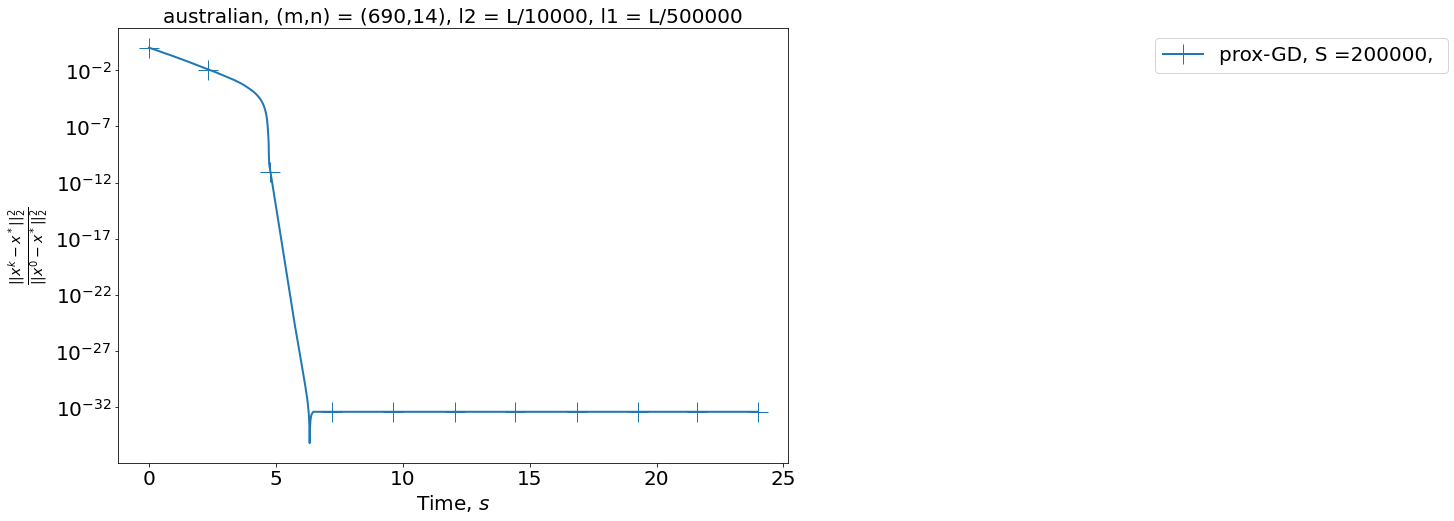

In [342]:
methods = [
         ['prox-GD', [gamma, l2, l1,S], 
           f', S ={S}, ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

In [343]:
alphas = [1, 0.1, 0.01]
S = min(l2 ** 2 * R ** 2 / epsilon ** 2, 200000)

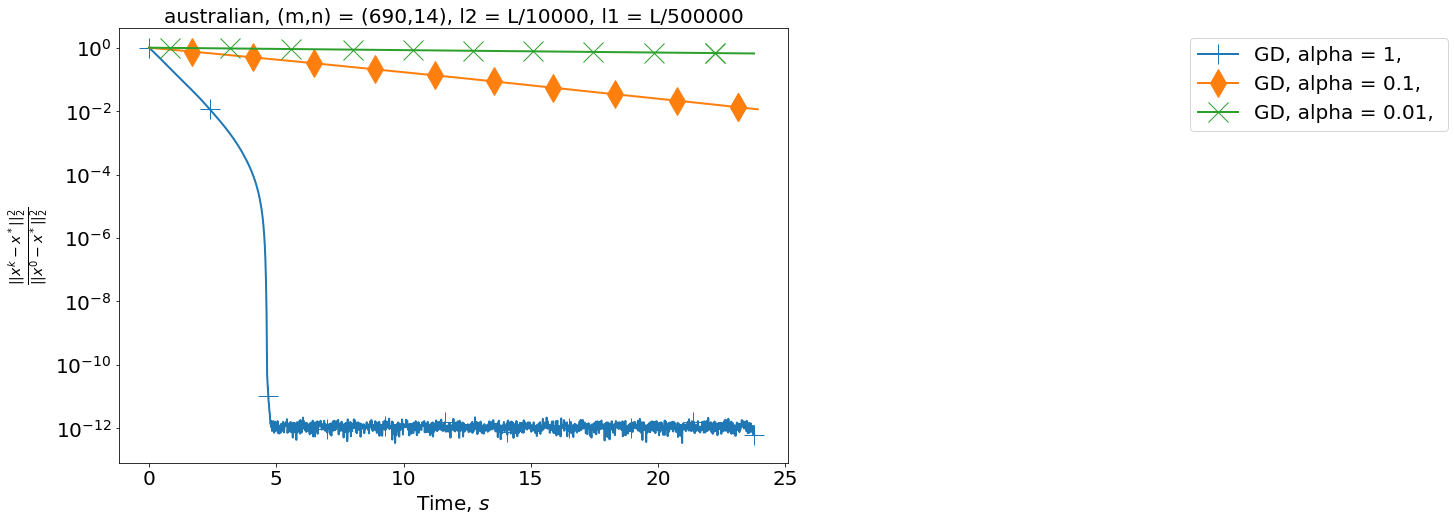

In [344]:
methods = []
mode_y = 'squared_distances'
mode_x = 'time'
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))
for alpha in alphas:
    gamma = alpha / (L + l2)
    res = gd(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
         sparse=sparse, l1=l1, S=S, max_t=np.inf,
         save_info_period=save_info_period, 
         x_star=x_star, f_star=f_star)
    methods.append(
             ['GD', [gamma,l2, l1, S], 
               f', alpha = {alpha}, ', None])

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

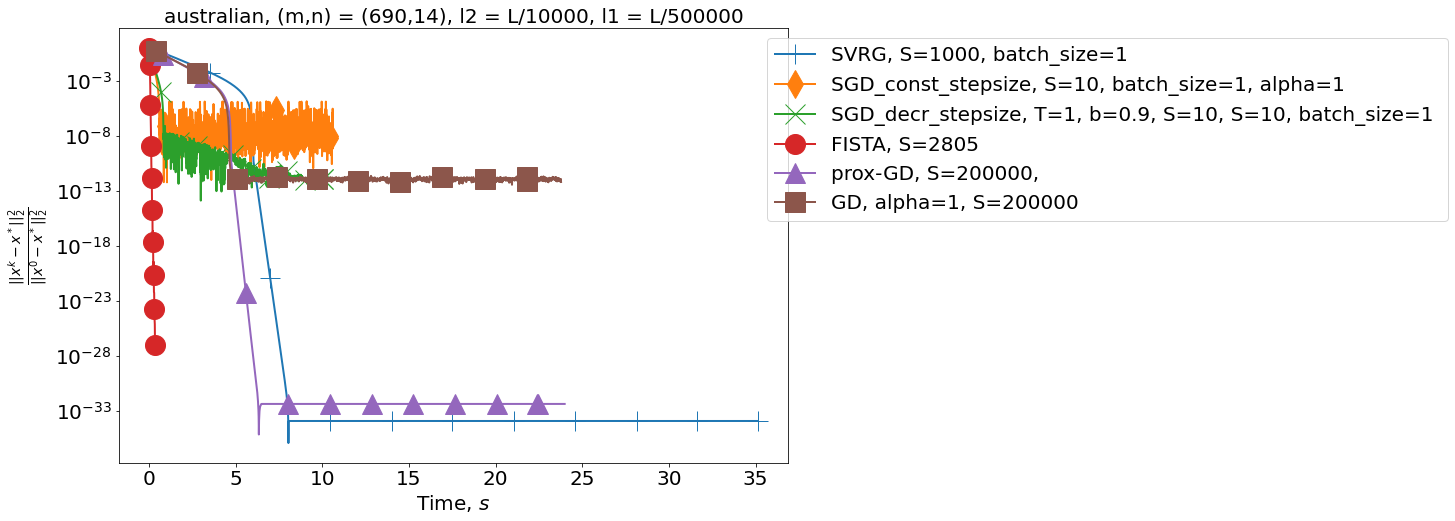

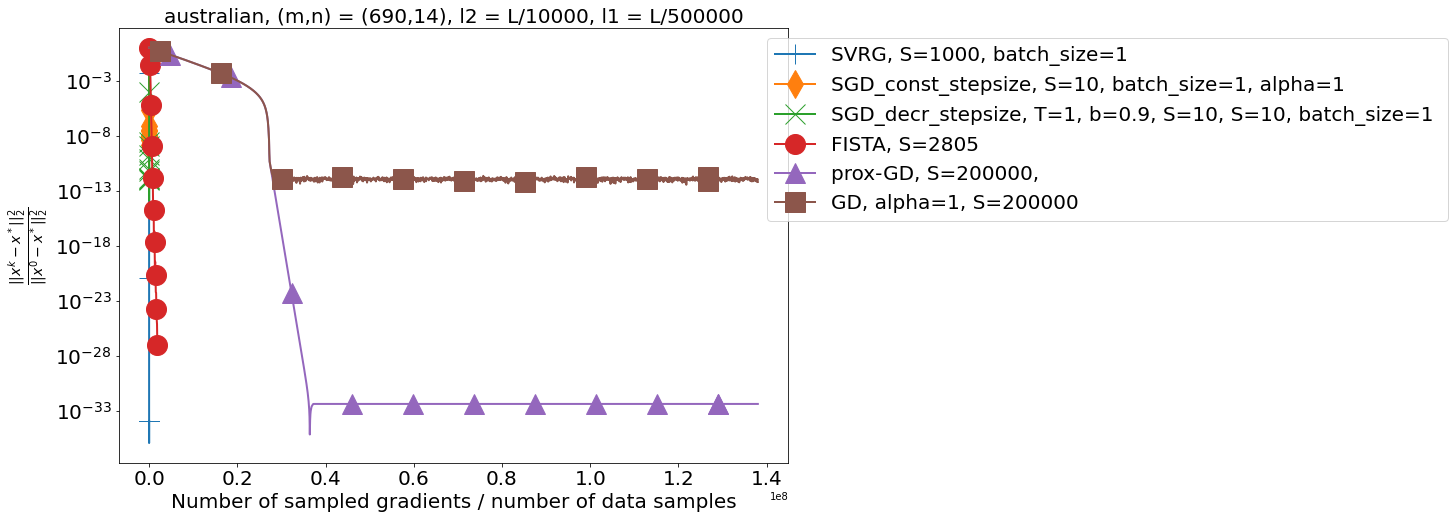

In [355]:
methods = [
    ['SVRG', [1.0/(6*(L+l2)), l2, l1, 1000, int(2*m/1), 1], f', S=1000, batch_size=1', None],
    ['SGD_const_stepsize', [1/(L+l2), l2, l1, 1000, 1], f', S=10, batch_size=1, alpha=1', None],
    ['SGD_decr_stepsize', [[1/(L+l2), 10, 0.9], l2, l1, 1000, 1], f', T=1, b=0.9, S=10, S=10, batch_size=1 ', None],
    ['FISTA', [l2, l1, 2805], f', S=2805 ', None],
    ['prox-GD', [1/L, l2, l1, 200000], f', S=200000, ', None],
    ['GD', [1/(L+l2),l2, l1, 200000], f', alpha=1, S=200000 ', None]
]
mode_y = 'squared_distances'
mode_xs = ['time', 'data_passes']
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

for mode_x in mode_xs:
    args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
    make_plots(args=args_for_plots)
    plt.show()